## Import libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

np.random.seed(1008)
sns.set(style='white', context='notebook', palette='deep')
plt.style.use('fivethirtyeight')

## Load data

In [2]:
dataset = pd.read_pickle(r'./data/raw_features_DDupdated_212.pkl')
dataset

icu_outcome  age  sex  pregnant  race  ethn    bmi  \
001_00001            1   65    0       0.0     7     1  46.60   
001_00002            1   73    1       0.0     7     1  35.42   
001_00003            1   73    0       0.0     7     1  22.75   
001_00004            1   30    1       0.0     7     1  44.95   
001_00005            1   62    0       0.0     7     1  32.95   
...                ...  ...  ...       ...   ...   ...    ...   
003_00055            0   90    1       0.0     3     2  24.05   
003_00056            0   65    0       0.0     6     2  39.34   
003_00057            0   78    1       0.0     6     2  28.22   
003_00059            0   33    1       0.0     6     2  41.02   
003_00060            1   47    1       0.0     6     1  28.32   

           previous_surgeries  travel  Primary Contact  ...  \
001_00001                 0.0       0                2  ...   
001_00002                 1.0       0                2  ...   
001_00003                 0.0       0                1  ...   
001_00004                 1.0       1                2  ...   
001_00005                 NaN       0                0  ...   
...                       ...     ...              ...  ...   
003_00055                 1.0       0                1  ...   
003_00056                 1.0       0                0  ...   
003_00057                 0.0       0                0  ...   
003_00059                 0.0       0                1  ...   
003_00060                 1.0       0                2  ...   

           Coagulation Profile  il6  D-Dimer  Procalcitonin  \
001_00001                  NaN  NaN     1.56           0.45   
001_00002                  NaN  NaN     7.52           0.16   
001_00003                 23.1  NaN     2.75           5.15   
001_00004                  NaN  NaN     1.71           0.45   
001_00005                  NaN  NaN     0.54           0.23   
...                        ...  ...      ...            ...   
003_00055                  NaN  NaN     0.48           0.22   
003_00056                  NaN  NaN     0.23            NaN   
003_00057                  NaN  NaN     0.15           0.20   
003_00059                  NaN  NaN     0.44           0.11   
003_00060                  NaN  5.0     0.40           0.37   

           Arterial Blood pH  Bicarbonate  Partial pressure of oxygen  \
001_00001               7.34         26.0                       129.0   
001_00002               7.28         19.0                        76.0   
001_00003               7.41         18.0                        77.0   
001_00004               7.45         22.0                        98.0   
001_00005               7.20         27.0                       178.0   
...                      ...          ...                         ...   
003_00055               7.30         16.7                        36.0   
003_00056                NaN          NaN                         NaN   
003_00057                NaN          NaN                         NaN   
003_00059                NaN          NaN                         NaN   
003_00060               7.43         26.0                        61.0   

           Partial pressure of carbon dioxide  Oxygen saturation   SpO2  
001_00001                                47.0               99.0   53.0  
001_00002                                39.0               95.0   48.0  
001_00003                                29.0               98.0  100.0  
001_00004                                31.0               99.0   96.0  
001_00005                                67.0               99.0   96.0  
...                                       ...                ...    ...  
003_00055                                34.0               72.1   94.0  
003_00056                                 NaN                NaN   97.0  
003_00057                                 NaN                NaN   99.0  
003_00059                                 NaN                NaN   98.0  
003_00060                

## Data pre-processing

### Check for null or missing values

In [3]:
pd.options.display.width = 0

# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

dataset.info()
#dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 001_00001 to 003_00060
Data columns (total 84 columns):
icu_outcome                               212 non-null int64
age                                       212 non-null int64
sex                                       212 non-null int64
pregnant                                  212 non-null float64
race                                      212 non-null int64
ethn                                      212 non-null int64
bmi                                       190 non-null float64
previous_surgeries                        199 non-null float64
travel                                    212 non-null int64
Primary Contact                           212 non-null int64
Secondary Contact                         212 non-null int64
Other Contact                             212 non-null int64
Work Contact                              203 non-null float64
Immuno-compromised                        212 non-null int64
Cardiac history         

### Dropping features with >60% missing values

Text(0, 0.5, '% missing values')

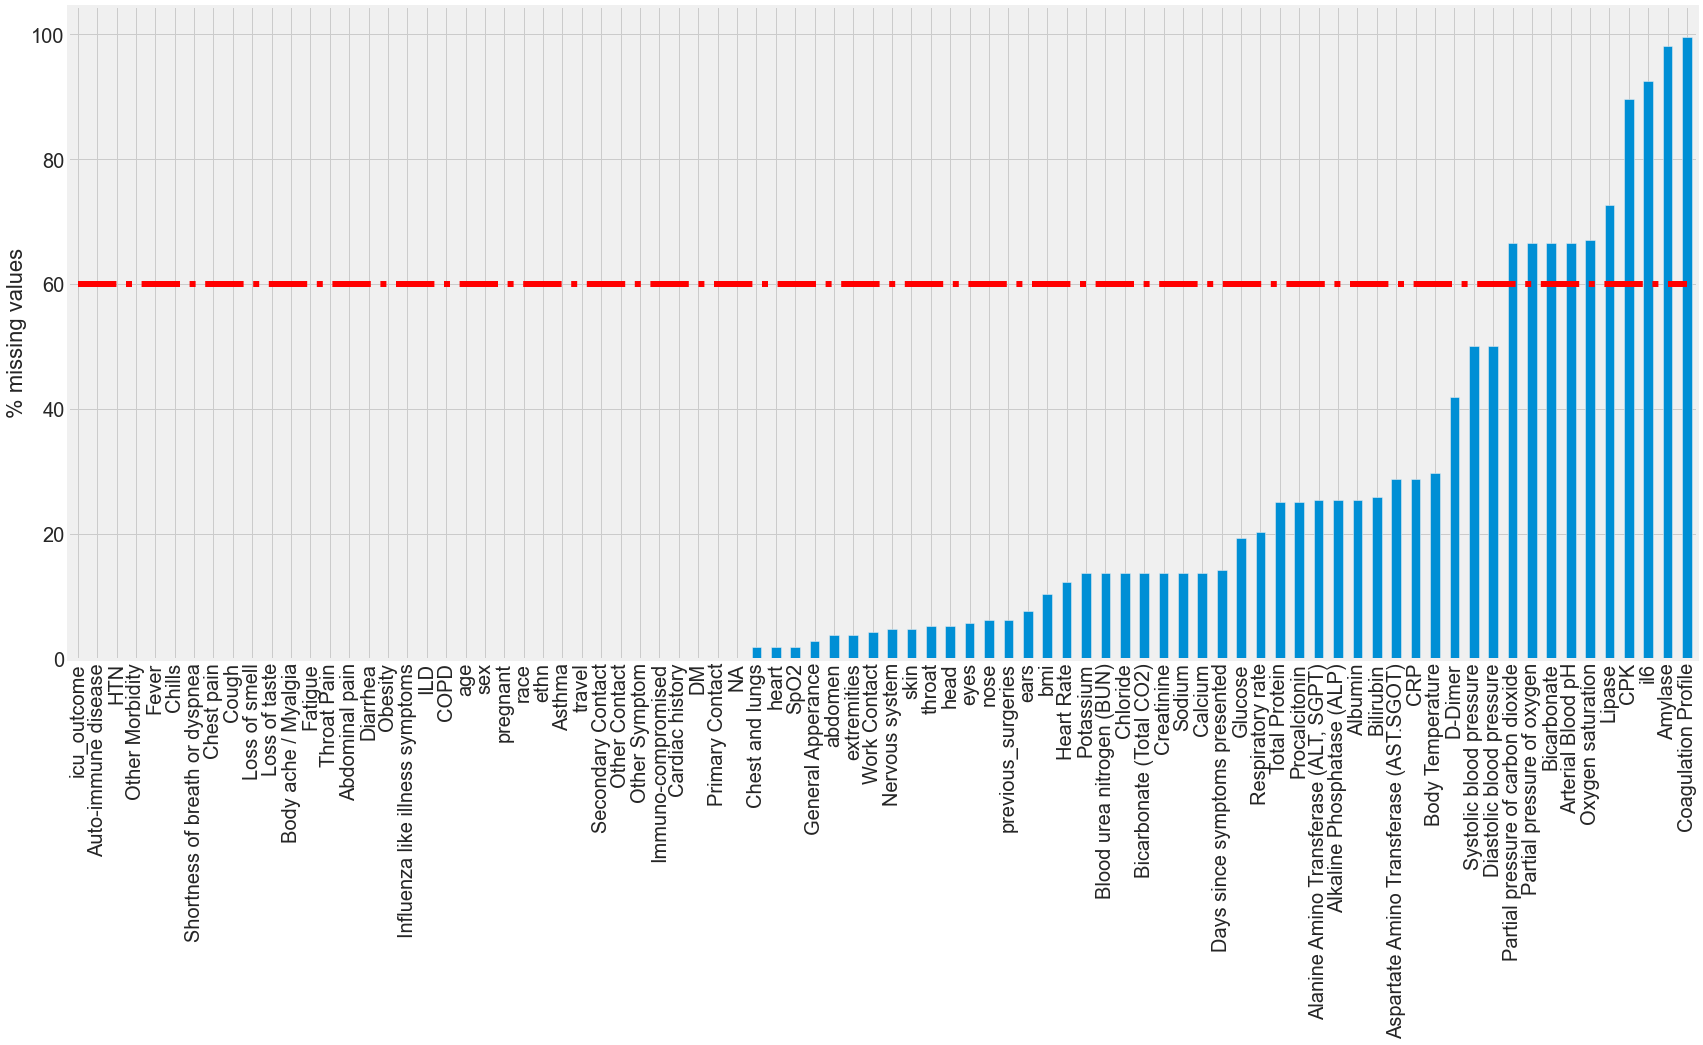

In [4]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing, 
                                'no_of_missing': dataset.isnull().sum()})
missing_value_df.sort_values('percent_missing', inplace=True)
plt.figure(figsize=(26,12))
missing_value_df.percent_missing.plot.bar(fontsize=20)
plt.plot(np.arange(len(dataset.columns)), np.ones(len(dataset.columns))*60, '-.', color='red', linewidth=6)
plt.grid(True)
plt.ylabel('% missing values', fontsize=22)

In [6]:
if len(dataset)==212:
    dataset.drop(['Partial pressure of carbon dioxide', 'Partial pressure of oxygen', 'Bicarbonate', 
                  'Arterial Blood pH', 'Oxygen saturation', 'Lipase', 'CPK', 'il6', 'Amylase',
                  'Coagulation Profile'], axis=1, inplace=True)
elif len(dataset)==188:   
    dataset.drop(['Partial pressure of carbon dioxide', 'Partial pressure of oxygen', 'Bicarbonate', 
                  'Arterial Blood pH', 'Oxygen saturation', 'Lipase', 'CPK', 'il6', 'Amylase', 
                  'Coagulation Profile'], axis=1, inplace=True)
elif len(dataset)==156:
    dataset.drop(['Partial pressure of carbon dioxide', 'Partial pressure of oxygen', 'Bicarbonate',
                  'Arterial Blood pH', 'Oxygen saturation', 'Lipase'], axis=1, inplace=True)
dataset.tail(10)

icu_outcome  age  sex  pregnant  race  ethn    bmi  \
003_00048            0   19    1       0.0     6     2  26.26   
003_00049            0   93    1       0.0     2     2  24.80   
003_00050            0   92    0       0.0     6     2  20.75   
003_00053            0   21    1       1.0     6     1  22.93   
003_00054            1   85    1       0.0     6     2  30.64   
003_00055            0   90    1       0.0     3     2  24.05   
003_00056            0   65    0       0.0     6     2  39.34   
003_00057            0   78    1       0.0     6     2  28.22   
003_00059            0   33    1       0.0     6     2  41.02   
003_00060            1   47    1       0.0     6     1  28.32   

           previous_surgeries  travel  Primary Contact  ...  \
003_00048                 1.0       0                1  ...   
003_00049                 1.0       0                0  ...   
003_00050                 0.0       0                0  ...   
003_00053                 0.0       0                0  ...   
003_00054                 0.0       0                0  ...   
003_00055                 1.0       0                1  ...   
003_00056                 1.0       0                0  ...   
003_00057                 0.0       0                0  ...   
003_00059                 0.0       0                1  ...   
003_00060                 1.0       0                2  ...   

           Blood urea nitrogen (BUN)  Creatinine  Alkaline Phosphatase (ALP)  \
003_00048                        7.0        0.67                        55.0   
003_00049                       41.0        1.20                       105.0   
003_00050                       48.0        1.80                        96.0   
003_00053                        7.0        0.60                       130.0   
003_00054                      112.0        3.40                        71.0   
003_00055                       32.0        1.00                        87.0   
003_00056                       18.0        0.63                       135.0   
003_00057                       28.0        0.60                       107.0   
003_00059                       16.0        0.80                        91.0   
003_00060                       10.0        0.50                       198.0   

           Alanine Amino Transferase (ALT, SGPT)  \
003_00048                                   44.0   
003_00049                                   17.0   
003_00050                                   29.0   
003_00053                                   14.0   
003_00054                                   34.0   
003_00055                                   29.0   
003_00056                                    5.0   
003_00057                                   15.0   
003_00059                                   43.0   
003_00060                                   60.0   

           Aspartate Amino Transferase (AST.SGOT)  Bilirubin   CRP  D-Dimer  \
003_00048                                    39.0        0.3   2.5     0.98   
003_00049                                    56.0        0.6   NaN      NaN   
003_00050                                    52.0        0.5  36.8      NaN   
003_00053                                    22.0        0.3   4.7     0.82   
003_00054                                    40.0        0.3   0.6     0.39   
003_00055                                    50.0        0.2   4.8     0.48   
003_00056                                    16.0        0.2   5.1     0.23   
003_00057                                    27.0        0.3   2.1     0.15   
003_00059                                    42.0        0.4   7.7     0.44   
003_00060                                    66.0        0.6   6.2     0.40   

           Procalcitonin  SpO2  
003_00048            NaN  96.0  
003_00049            NaN  83.0  
003_00050           2.19  92.0  
003_00053           0.11  96.0  
003_00054            NaN  97.0  
003_00055           0.22  94.0  
003_00056            NaN  97.0  
003_00057    

### Outlier detection

In [7]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

dataset.columns.to_series().groupby(dataset.dtypes).groups

Outliers_to_drop = detect_outliers(dataset,2,["bmi","Days since symptoms presented",
                                              'Systolic blood pressure', 'Diastolic blood pressure', 
        'Heart Rate', 'Respiratory rate', 'Body Temperature',
        'Glucose', 'Calcium',
        'Albumin', 'Total Protein', 'Sodium', 'Potassium',
        'Bicarbonate (Total CO2)', 'Chloride', 'Blood urea nitrogen (BUN)',
        'Creatinine', 'Alkaline Phosphatase (ALP)',
        'Alanine Amino Transferase (ALT, SGPT)',
        'Aspartate Amino Transferase (AST.SGOT)', 'Bilirubin', 'CRP',
        'D-Dimer', 'Procalcitonin'])

C:\Users\Harikrishna\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [8]:
dataset.loc[Outliers_to_drop]

Empty DataFrame
Columns: [icu_outcome, age, sex, pregnant, race, ethn, bmi, previous_surgeries, travel, Primary Contact, Secondary Contact, Other Contact, Work Contact, Immuno-compromised, Cardiac history, DM, COPD, Asthma, ILD, Obesity, Auto-immune disease, HTN, Other Morbidity, Fever, Chills, Shortness of breath or dyspnea, Chest pain, Cough, Loss of smell, Loss of taste, Body ache / Myalgia, Fatigue, Throat Pain, Abdominal pain, Diarrhea, Influenza like illness symptoms, NA, Other Symptom, Days since symptoms presented, General Apperance, head, eyes, ears, nose, throat, Chest and lungs, heart, abdomen, extremities, Nervous system, skin, Systolic blood pressure, Diastolic blood pressure, Heart Rate, Respiratory rate, Body Temperature, Glucose, Calcium, Albumin, Total Protein, Sodium, Potassium, Bicarbonate (Total CO2), Chloride, Blood urea nitrogen (BUN), Creatinine, Alkaline Phosphatase (ALP), Alanine Amino Transferase (ALT, SGPT), Aspartate Amino Transferase (AST.SGOT), Bilirubin, CRP, D-Dimer, Procalcitonin, SpO2]
Index: []

[0 rows x 74 columns]

Apparently, there are not any outliers in this dataset.

### Renaming features

In [9]:
dataset.rename(columns={"Influenza like illness symptoms": "Influenza like symp.",
                         "Shortness of breath or dyspnea": "Dyspnea",
                        "Aspartate Amino Transferase (AST.SGOT)": "AST/SGOT",
                        "Alanine Amino Transferase (ALT, SGPT)": "ALT/SGPT",
                       "Blood urea nitrogen (BUN)": "BUN"}, inplace=True)

### Data statistics

In [10]:
dataset.describe()

icu_outcome         age         sex    pregnant        race  \
count   212.000000  212.000000  212.000000  212.000000  212.000000   
mean      0.349057   53.212264    0.419811    0.094340    6.358491   
std       0.477800   18.442616    0.494696    0.390122    1.292990   
min       0.000000   12.000000    0.000000    0.000000    2.000000   
25%       0.000000   40.750000    0.000000    0.000000    6.000000   
50%       0.000000   53.000000    0.000000    0.000000    7.000000   
75%       1.000000   67.250000    1.000000    0.000000    7.000000   
max       1.000000   93.000000    1.000000    2.000000    7.000000   

             ethn         bmi  previous_surgeries      travel  \
count  212.000000  190.000000          199.000000  212.000000   
mean     1.504717   29.733158            0.447236    0.070755   
std      0.670980    8.398951            0.498462    0.257022   
min      1.000000    0.000000            0.000000    0.000000   
25%      1.000000   25.315000            0.000000    0.000000   
50%      1.000000   29.000000            0.000000    0.000000   
75%      2.000000   32.860000            1.000000    0.000000   
max      3.000000   84.050000            1.000000    1.000000   

       Primary Contact  ...         BUN  Creatinine  \
count       212.000000  ...  183.000000  183.000000   
mean          1.023585  ...   20.953880    1.358634   
std           0.910398  ...   21.983436    1.973725   
min           0.000000  ...    0.560000    0.370000   
25%           0.000000  ...    9.500000    0.700000   
50%           1.000000  ...   13.000000    0.840000   
75%           2.000000  ...   21.000000    1.100000   
max           2.000000  ...  137.000000   17.590000   

       Alkaline Phosphatase (ALP)    ALT/SGPT    AST/SGOT   Bilirubin  \
count                  158.000000  158.000000  151.000000  157.000000   
mean                    94.348101   45.772152   59.622517    0.734395   
std                     56.553670   38.039353   49.433827    1.674343   
min                     29.000000    5.000000   13.000000    0.200000   
25%                     64.000000   20.250000   30.500000    0.300000   
50%                     80.000000   35.500000   47.000000    0.500000   
75%                    105.000000   56.000000   67.000000    0.700000   
max                    417.000000  247.000000  355.000000   20.500000   

              CRP     D-Dimer  Procalcitonin        SpO2  
count  151.000000  123.000000     159.000000  208.000000  
mean   109.153642    1.682439       0.927170   92.894231  
std     96.087507    2.968486       3.498916    7.115905  
min      0.600000    0.140000       0.020000   48.000000  
25%     33.200000    0.400000       0.110000   91.000000  
50%     91.700000    0.810000       0.180000   95.000000  
75%    168.900000    1.435000       0.425000   97.000000  
max    470.800000   20.000000      31.900000  100.000000  

[8 rows x 74 columns]

## Correlation Matrix

Next, let's look at the correlation in data and plot correlation matrix. This will give us an idea about which features are highly correlated with ICU outcomes and which are not. This gives us an insight about the data at hand and could also be useful in reducing the dimensionality of dataset and for data imputation.

In [42]:
# impute missing data with iterative imputation
imp0 = IterativeImputer(max_iter=10, n_nearest_features=3, random_state=0)
fit_dataset = imp0.fit(dataset)
imputed_dataset = imp0.transform(dataset)
imputed_dataset_df = dataset
for i in range(len(dataset)):
    imputed_dataset_df.iloc[i] = imputed_dataset[i]


(74.5, -0.5)

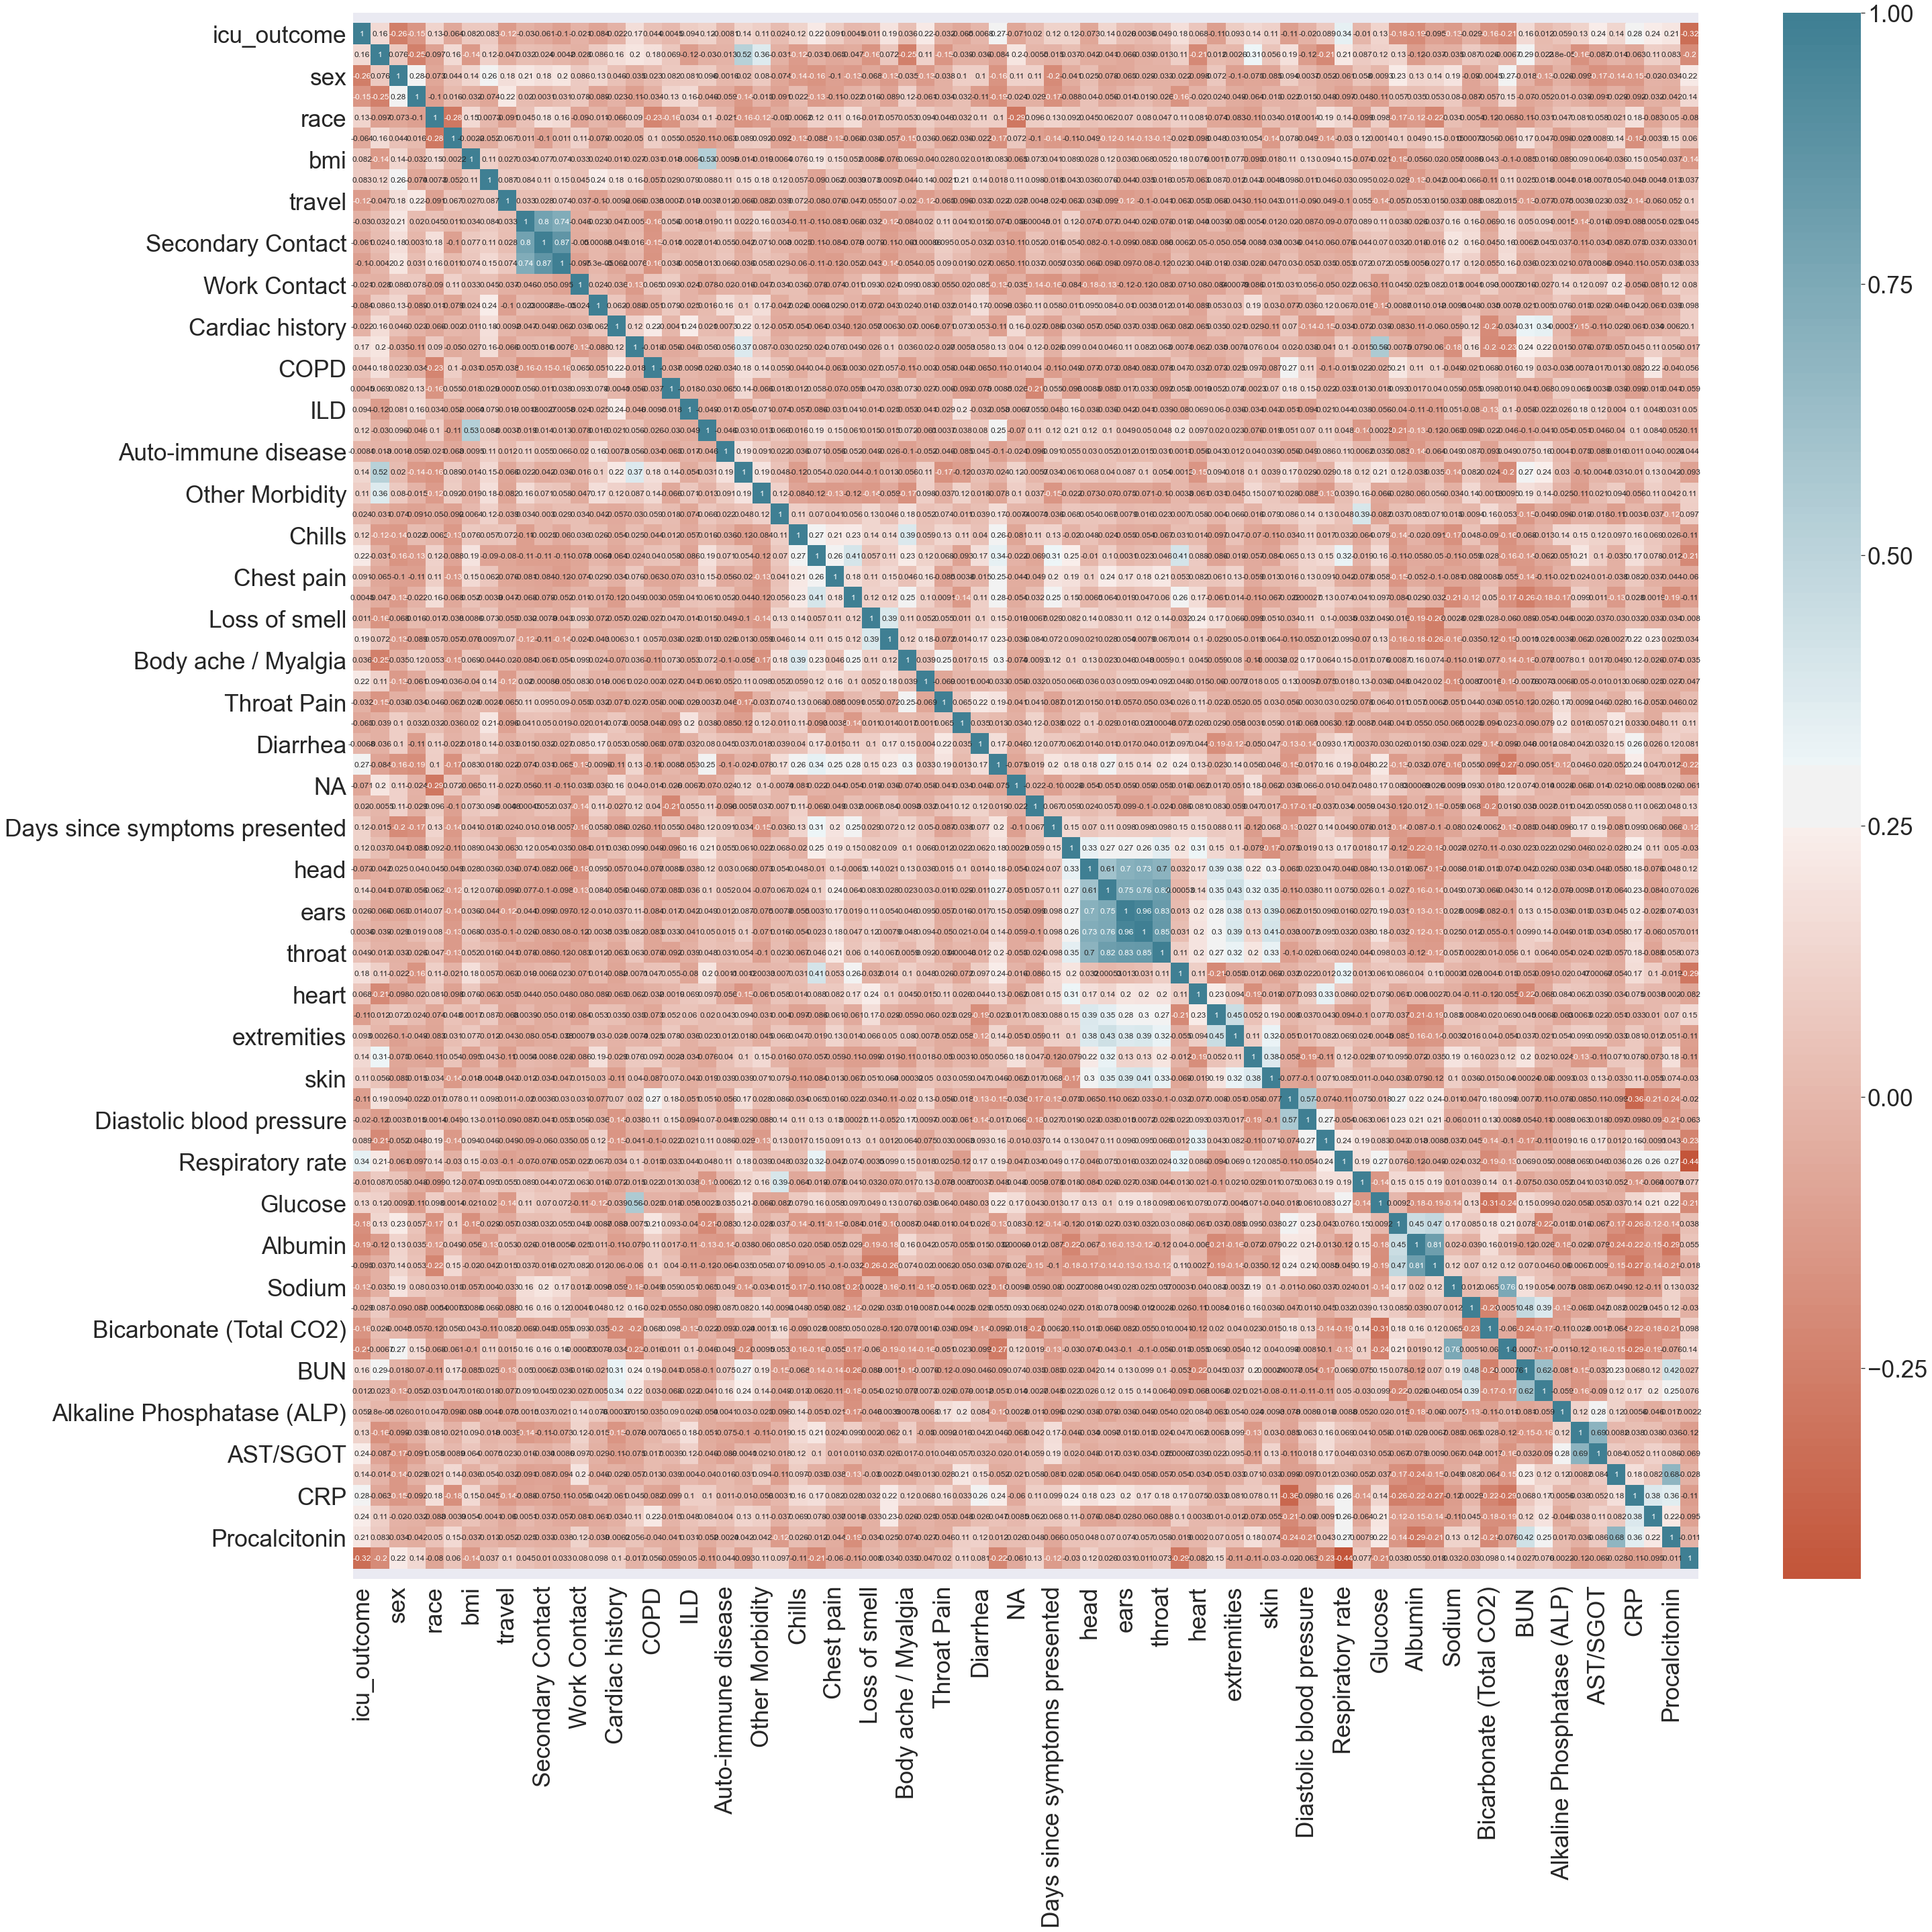

In [43]:
# Correlation matrix between numerical values 
plt.figure(figsize=(40,40))
dataset_corr = dataset.corr(min_periods = int(0.6*len(dataset)))

sns.set(font_scale=3.2)
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)

ax = sns.heatmap(dataset_corr, annot=True, cbar=True, cmap=sns.diverging_palette(20, 220, n=200), label="big", annot_kws={"size":12})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Let's find and plot 10 most highly (positivly or negatively) correlated features with ICU outcome.

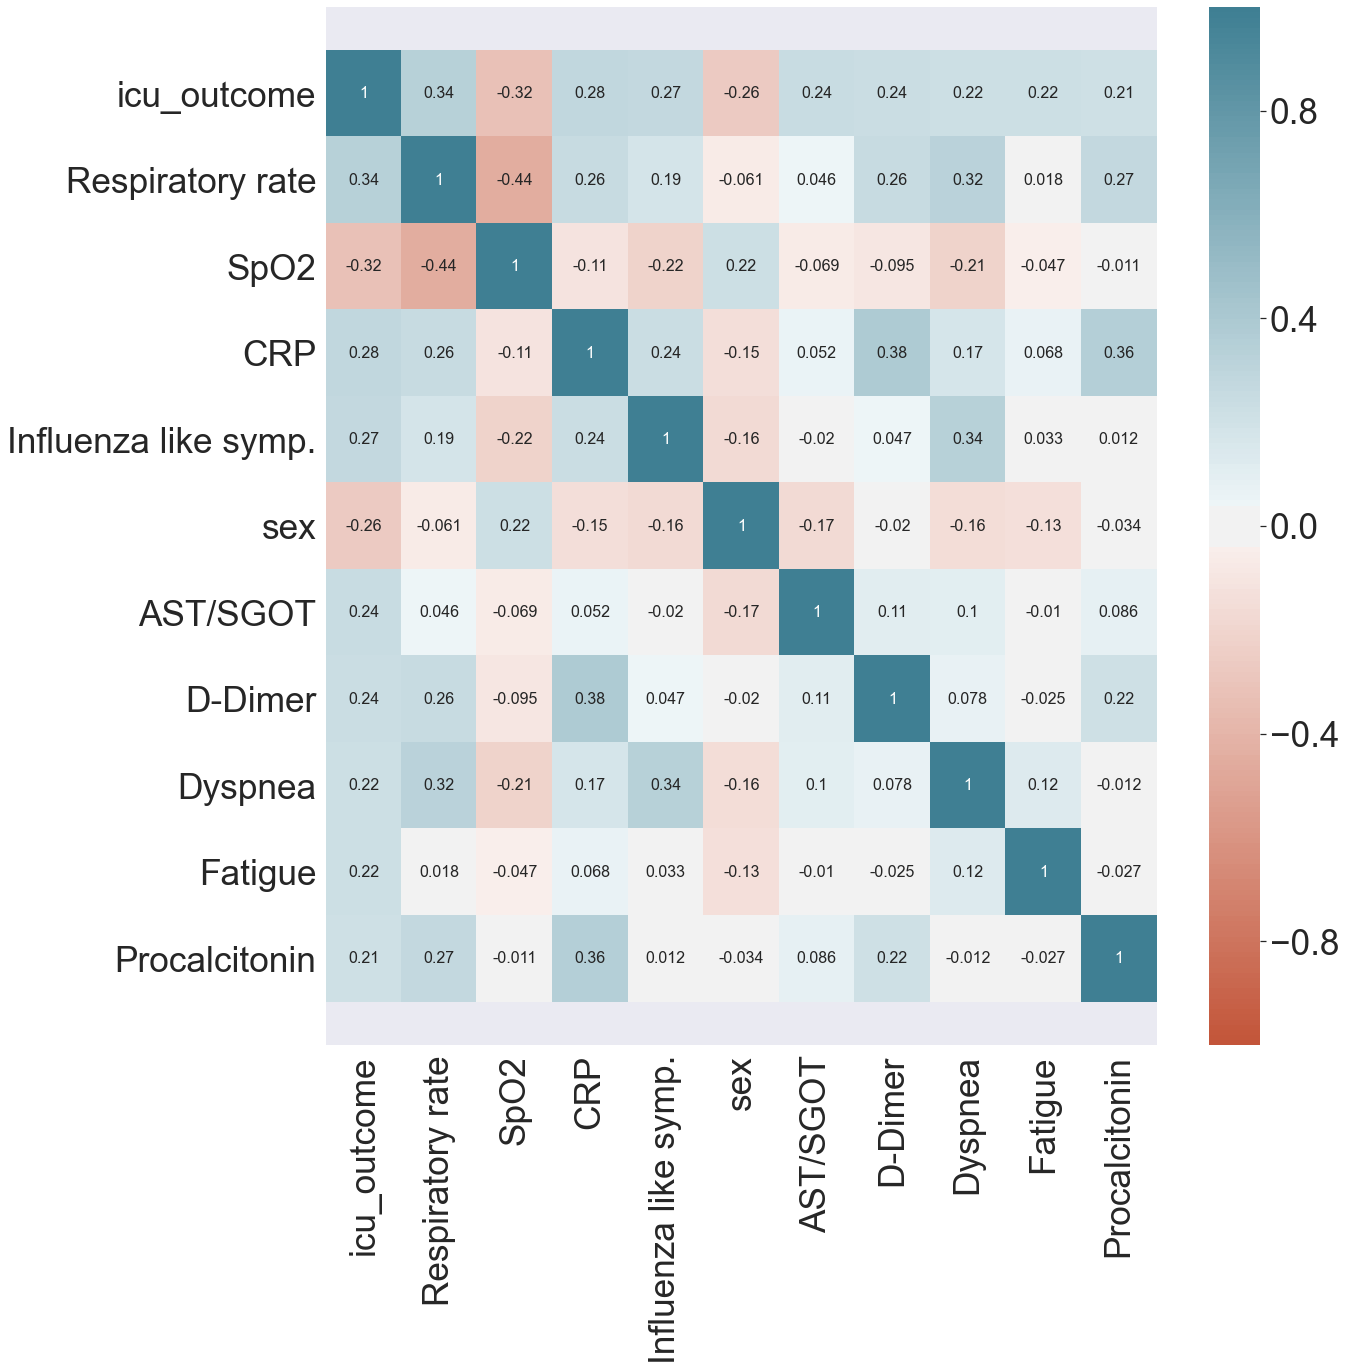

In [44]:
## Find top features
top_row = dataset_corr['icu_outcome'].abs()
sorted_top_row = top_row.sort_values(ascending=False)

imp10_df = dataset.loc[:, sorted_top_row.index[:11]]

corr10_df = imp10_df.corr()
plt.figure(figsize=(20,20))
sns.set(font_scale=3.2)
ax = sns.heatmap(corr10_df, annot=True, cbar=True, cmap=sns.diverging_palette(20, 220, n=200),
                  label="big", annot_kws={"size":16}, vmin=-1, vmax=1)


bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(sorted_top_row.index[:11], rotation=90)
plt.tight_layout()

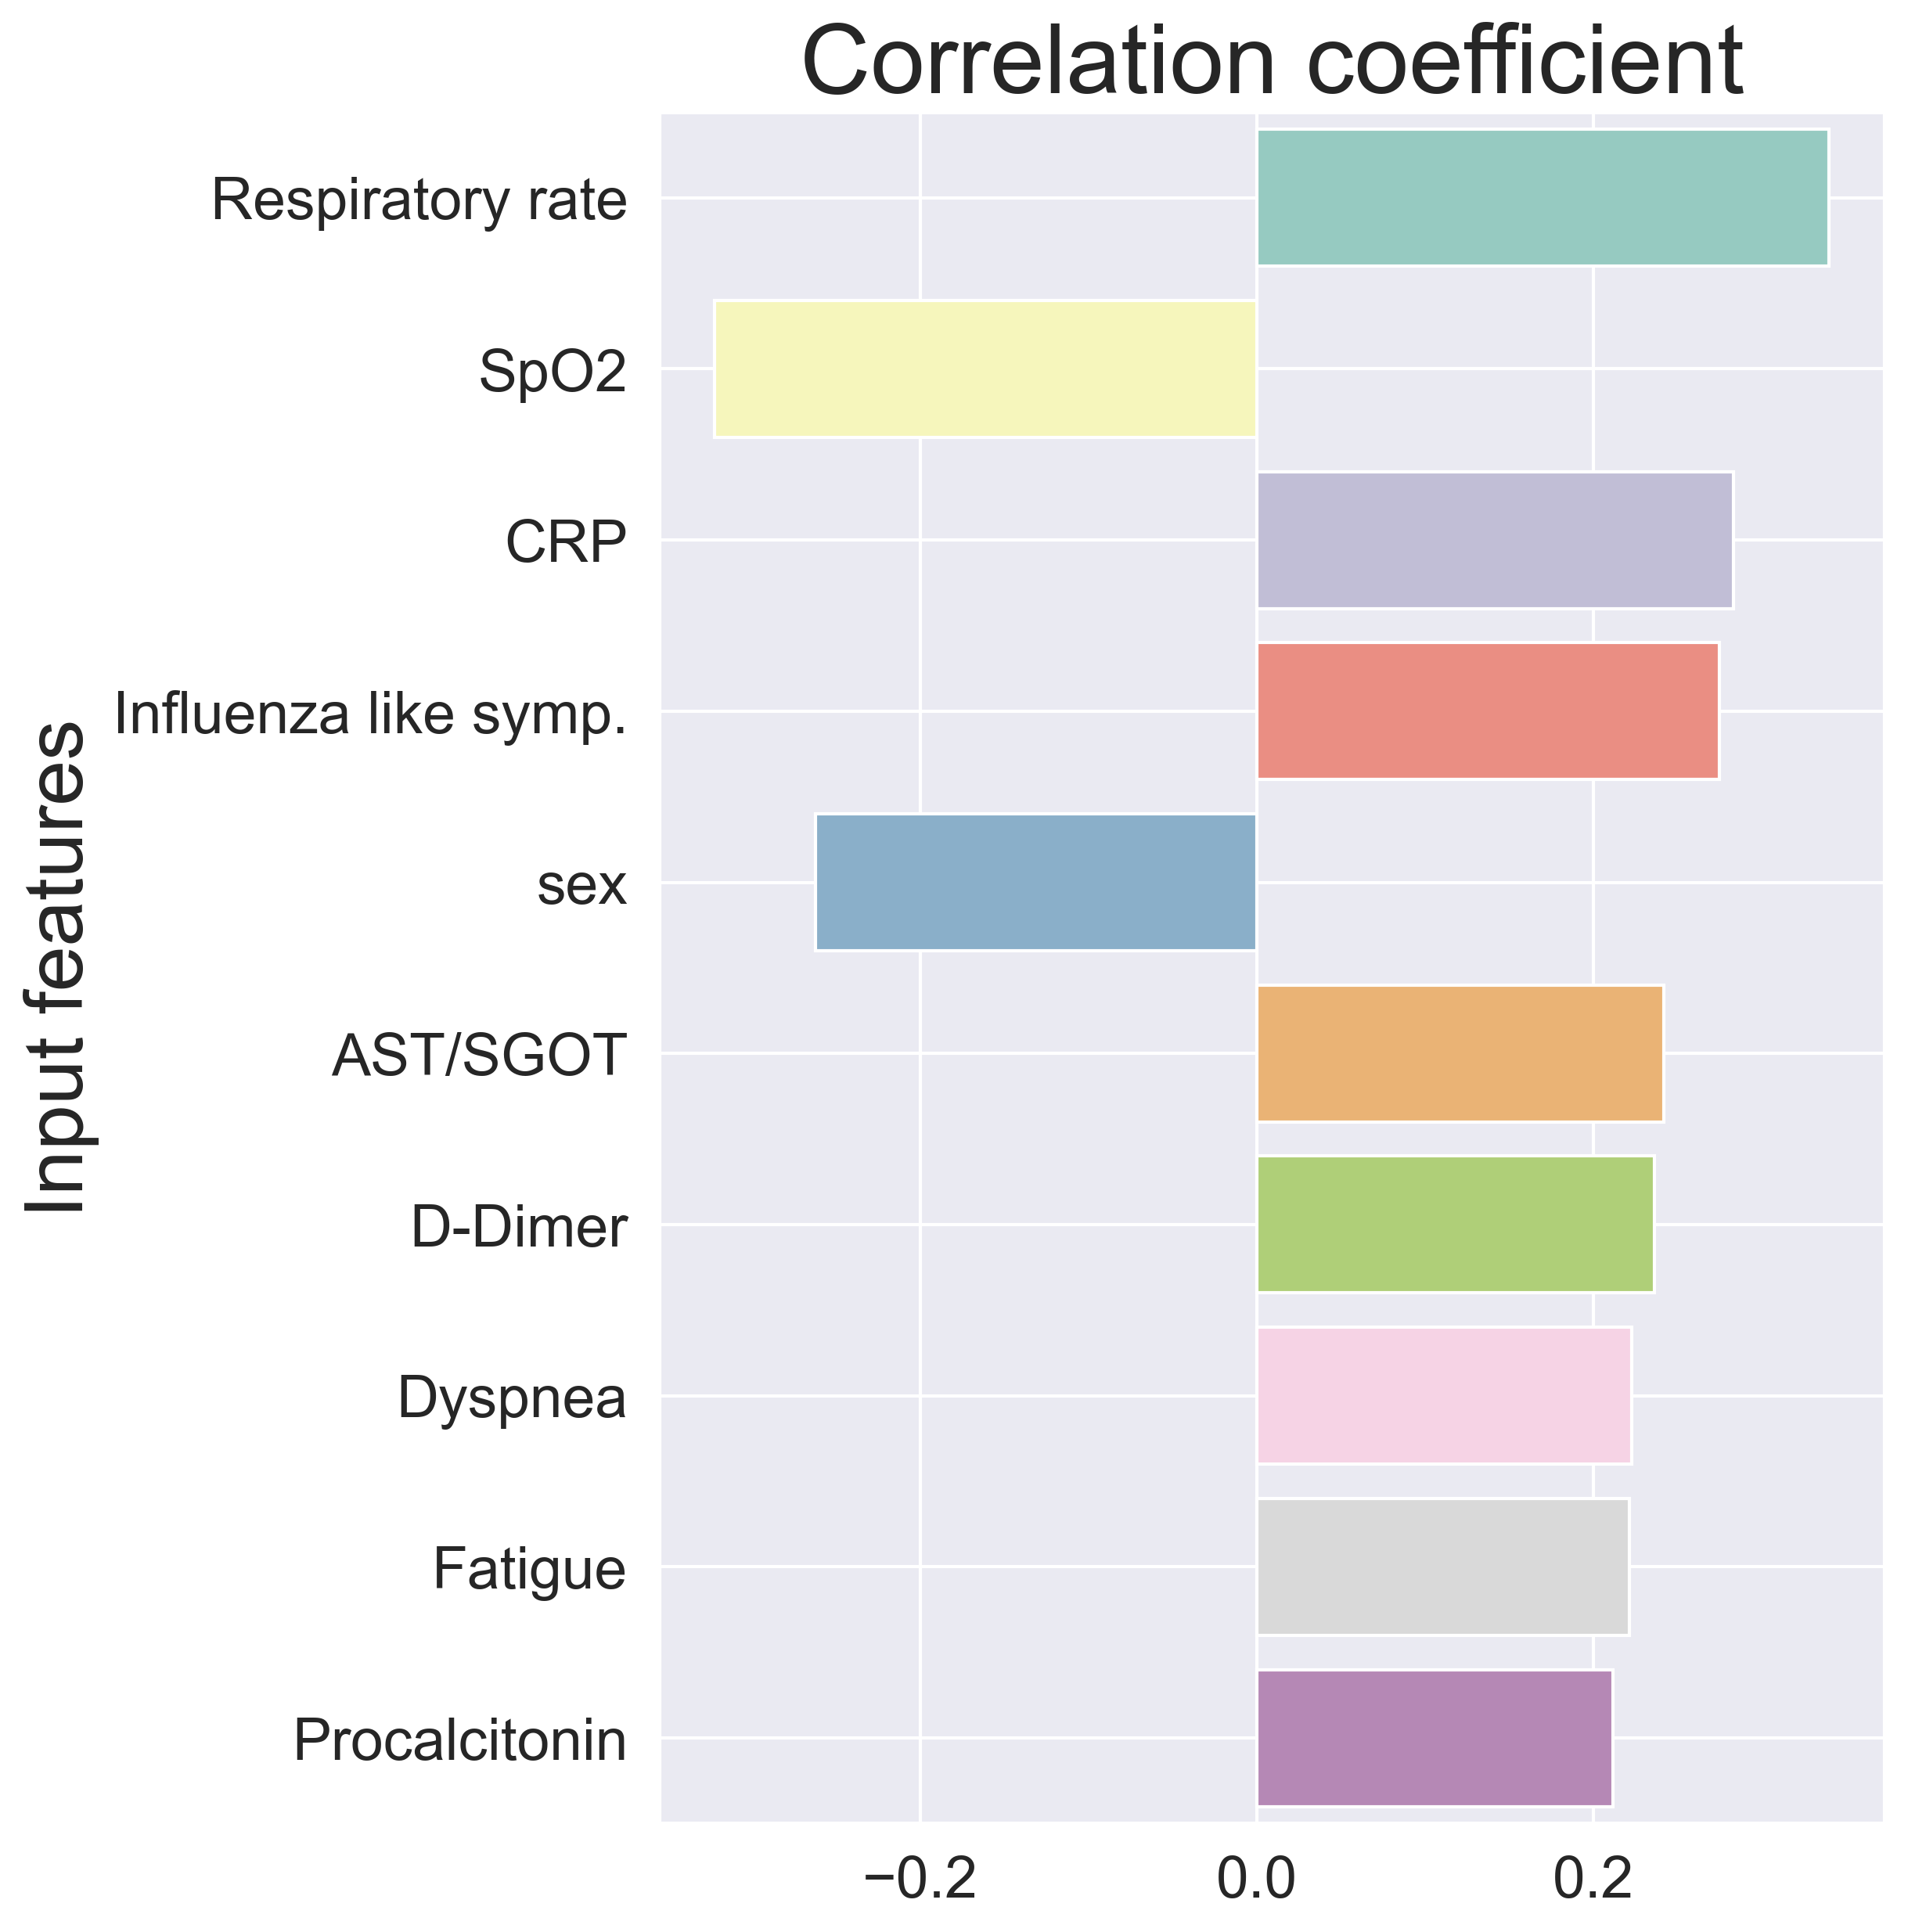

In [46]:
sns.set(font_scale=1.4)
corr10_df.reset_index(inplace=True)
corr10_df.loc[:, ['index', 'icu_outcome']]
plt.figure(figsize=(6,9), dpi=300)
g = sns.barplot(y="index", x="icu_outcome", 
                data = corr10_df.loc[1:, ['index', 'icu_outcome']], palette="Set3",orient = "h")
plt.title("Correlation coefficient", fontsize=30)
g.set_ylabel("Input features", fontsize=25)
g.set_xlabel("", fontsize=25)

g.tick_params(labelsize=18)


plt.grid(True)

## Modeling

Split `dataset` into features (`X_data`) and labels (`Y_data`).

In [13]:
dataset["icu_outcome"] = dataset["icu_outcome"].astype(int)

Y_data = dataset["icu_outcome"]
X_data = dataset.drop(labels = ["icu_outcome"], axis = 1)
X_data.head()

age  sex  pregnant  race  ethn    bmi  previous_surgeries  travel  \
001_00001   65    0       0.0     7     1  46.60                 0.0       0   
001_00002   73    1       0.0     7     1  35.42                 1.0       0   
001_00003   73    0       0.0     7     1  22.75                 0.0       0   
001_00004   30    1       0.0     7     1  44.95                 1.0       1   
001_00005   62    0       0.0     7     1  32.95                 NaN       0   

           Primary Contact  Secondary Contact  ...   BUN  Creatinine  \
001_00001                2                  2  ...  17.0        1.01   
001_00002                2                  2  ...  23.0        0.57   
001_00003                1                  1  ...  22.0        1.51   
001_00004                2                  2  ...   9.0        0.69   
001_00005                0                  0  ...  17.0        0.90   

           Alkaline Phosphatase (ALP)  ALT/SGPT  AST/SGOT  Bilirubin    CRP  \
001_00001                         NaN       NaN       NaN        NaN  169.0   
001_00002                       119.0      33.0      65.0        0.4   50.8   
001_00003                       288.0      11.0      51.0        2.1  147.3   
001_00004                        56.0     113.0       NaN        0.4   51.0   
001_00005                        77.0      21.0      36.0        0.5  240.2   

           D-Dimer  Procalcitonin   SpO2  
001_00001     1.56           0.45   53.0  
001_00002     7.52           0.16   48.0  
001_00003     2.75           5.15  100.0  
001_00004     1.71           0.45   96.0  
001_00005     0.54           0.23   96.0  

[5 rows x 73 columns]

Impute the missing values using [iterative imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)

In [17]:
random_state = 1008
n_test_folds = 5
n_val_folds = 5

imp0 = IterativeImputer(max_iter=10, n_nearest_features=3, random_state=0)
kfold = StratifiedKFold(n_splits=n_test_folds, random_state=random_state)#, shuffle=True)
print(kfold)

stratified_fold = []
for train_index, test_index in kfold.split(X_data, Y_data):
    stratified_fold.append(list(test_index))

cv_strategy = 'random'

StratifiedKFold(n_splits=5, random_state=1008, shuffle=False)


Next, we consider 6 different ML models (Adaptive Boosting, Random Forest, Extra tree Classifier, Gradient Boosting, Support Vector Machine, and Multi-layer perceptron) to predict ICU admission of patients given socio-demographical and clinical features at the time of admission. We tune the important hyper-parameters of all these models using two different cross-validation strategy ([grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)).

### AdaBoost Decision Tree Classifier

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished


Best parameters set found on development set:

{'n_estimators': 1, 'learning_rate': 3.7566859467129388, 'base_estimator__splitter': 'random', 'base_estimator__criterion': 'gini', 'algorithm': 'SAMME'}
Detailed classification report:
Confusion matrix:
[[15 13]
 [ 8  6]]
Accuracy:
0.5
ROC-AUC value:
0.4821428571428571
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished


Best parameters set found on development set:

{'n_estimators': 2, 'learning_rate': 8.751971959292606, 'base_estimator__splitter': 'random', 'base_estimator__criterion': 'entropy', 'algorithm': 'SAMME.R'}
Detailed classification report:
Confusion matrix:
[[20  7]
 [10  5]]
Accuracy:
0.5952380952380952
ROC-AUC value:
0.537037037037037
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


Best parameters set found on development set:

{'n_estimators': 2, 'learning_rate': 3.106764709651329, 'base_estimator__splitter': 'best', 'base_estimator__criterion': 'gini', 'algorithm': 'SAMME.R'}
Detailed classification report:
Confusion matrix:
[[22  5]
 [ 5 10]]
Accuracy:
0.7619047619047619
ROC-AUC value:
0.7407407407407407
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished


Best parameters set found on development set:

{'n_estimators': 2, 'learning_rate': 1.574123447320189, 'base_estimator__splitter': 'random', 'base_estimator__criterion': 'gini', 'algorithm': 'SAMME.R'}
Detailed classification report:
Confusion matrix:
[[24  4]
 [ 9  6]]
Accuracy:
0.6976744186046512
ROC-AUC value:
0.6285714285714286
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters set found on development set:

{'n_estimators': 2, 'learning_rate': 9.282941358083917, 'base_estimator__splitter': 'random', 'base_estimator__criterion': 'gini', 'algorithm': 'SAMME'}
Detailed classification report:
Confusion matrix:
[[14 14]
 [ 4 11]]
Accuracy:
0.5813953488372093
ROC-AUC value:
0.6166666666666667
Acc. on test set = 0.6272425249169435
ROCAUC on test set = 0.601031746031746


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished


Text(0.5, 1.0, 'ROC Curve (for test set) - AUC = 0.60')

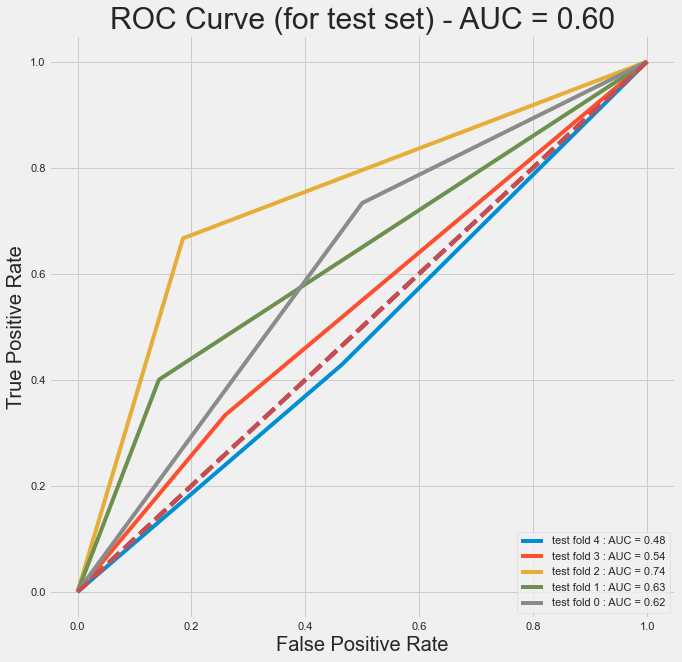

In [19]:
acc_adaboost = []
rocauc_adaboost = []
probs_adaboost = []

plt.figure(figsize=(10, 10))

# Scroll through whole dataset for 5-fold cross validation and testing
for i_test_fold in range(n_test_folds-1, -1, -1):
    test_indices = stratified_fold[i_test_fold]
    train_indices_list = stratified_fold[:i_test_fold] + stratified_fold[i_test_fold+1:]
    train_indices = [item for sublist in train_indices_list for item in sublist]
    ##########################################################
    #the above line is a list comprehension of following nested for loops.
    #train_indices = []
    #for sublist in train_indices_list:
    #    for item in sublist:
    #        train_indices.append(item)
    ##########################################################

    shuffled_train_ind = np.random.choice(train_indices, len(train_indices), replace=False)
    shuffled_test_ind = np.random.choice(test_indices, len(test_indices), replace=False)
    X_train = X_data.iloc[shuffled_train_ind]
    Y_train = Y_data[shuffled_train_ind]
    X_test = X_data.iloc[shuffled_test_ind]
    Y_test = Y_data[shuffled_test_ind] 
    fit_train = imp0.fit(X_train)
    test_imputed = imp0.transform(X_test)
    train_imputed = imp0.transform(X_train)
    
    for i in range(len(X_train)):
        X_train.iloc[i] = train_imputed[i]    
    for i in range(len(X_test)):
        X_test.iloc[i] = test_imputed[i]
          
    
    val_fold = StratifiedKFold(n_splits=n_val_folds, random_state=random_state)    
    
    DTC = DecisionTreeClassifier()
    adaDTC = AdaBoostClassifier(DTC, random_state=random_state)
    ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[1,2],
                  "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}   
    ada_param_dist = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[1,2],
                  "learning_rate":  10**np.random.uniform(0., 1., size=8)}   
    n_iter_search = 10
    
    # Select grid search or random search for cross-validation
    if cv_strategy == 'grid':
        clf = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=val_fold, scoring="roc_auc", 
                           n_jobs= 8, verbose = 1)
    elif cv_strategy == 'random':
        clf = RandomizedSearchCV(adaDTC, param_distributions = ada_param_dist, cv=val_fold, 
                                 scoring="roc_auc", n_jobs= 8, verbose = 1)
    
    clf.fit(X_train,Y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    adaDTC_best = clf.best_estimator_ 
    
    print("Detailed classification report:")
    y_true, y_pred = Y_test, clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    probs_adaboost.append(y_true)
    probs_adaboost.append(y_probs)

    
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Accuracy:")
    accuracy_test_fold = accuracy_score(y_true, y_pred)
    print(accuracy_test_fold)
    acc_adaboost.append(accuracy_test_fold)
    print("ROC-AUC value:")
    rocauc_test_fold = roc_auc_score(y_true, y_probs[:, 1])
    print(rocauc_test_fold)
    rocauc_adaboost.append(rocauc_test_fold)
    
    
    fpr, tpr, threshold = roc_curve(Y_test, y_probs[:,1])
    plt.plot(fpr, tpr, label = 'test fold {} : AUC = {:.2f}'.format(i_test_fold, rocauc_test_fold))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    print('==================================================================')
    
print("Acc. on test set = {}".format(np.mean(acc_adaboost)))
print("ROCAUC on test set = {}".format(np.mean(rocauc_adaboost)))
plt.title('ROC Curve (for test set) - AUC = {:.2f}'.format(np.mean(rocauc_adaboost)), fontsize=30)



### Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   20.2s finished


Best parameters set found on development set:

{'n_estimators': 161, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

Confusion matrix:
[[28  0]
 [11  3]]
Accuracy:
0.7380952380952381
ROC-AUC value:
0.7397959183673469
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   27.8s finished


Best parameters set found on development set:

{'n_estimators': 278, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 7, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

Confusion matrix:
[[27  0]
 [13  2]]
Accuracy:
0.6904761904761905
ROC-AUC value:
0.8222222222222222
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   19.4s finished


Best parameters set found on development set:

{'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

Confusion matrix:
[[25  2]
 [ 8  7]]
Accuracy:
0.7619047619047619
ROC-AUC value:
0.8617283950617284
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   19.5s finished


Best parameters set found on development set:

{'n_estimators': 164, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 5, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

Confusion matrix:
[[28  0]
 [11  4]]
Accuracy:
0.7441860465116279
ROC-AUC value:
0.8166666666666667
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   26.6s finished


Best parameters set found on development set:

{'n_estimators': 348, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

Confusion matrix:
[[24  4]
 [ 5 10]]
Accuracy:
0.7906976744186046
ROC-AUC value:
0.8761904761904762
Acc. on test set = 0.7450719822812847
ROCAUC on test set = 0.8233207357016881


Text(0.5, 1.0, 'ROC Curve (for test set) - AUC = 0.82')

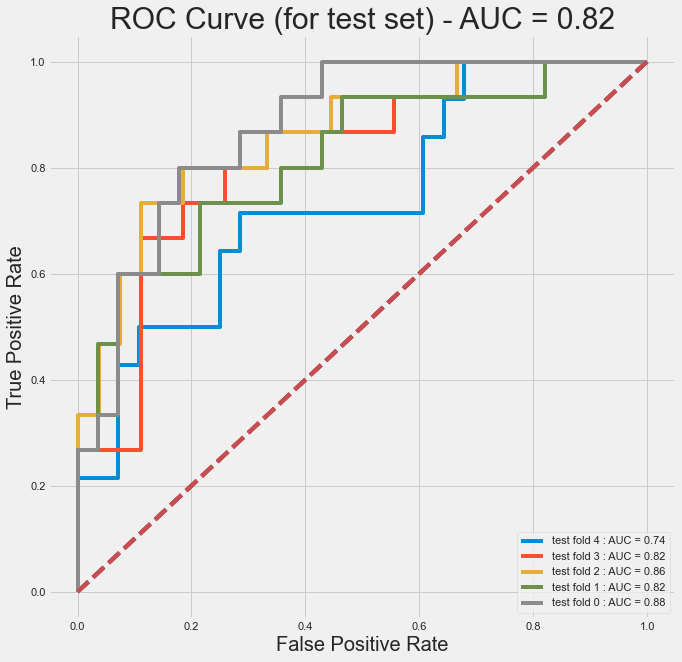

In [20]:
acc_rf = []
rocauc_rf = []
probs_rf = []
feat_imp_rf = np.zeros((len(X_data.columns), n_test_folds))
plt.figure(figsize=(10, 10))

# Scroll through whole dataset for 5-fold cross validation and testing
for i_test_fold in range(n_test_folds-1, -1, -1):
    test_indices = stratified_fold[i_test_fold]
    train_indices_list = stratified_fold[:i_test_fold] + stratified_fold[i_test_fold+1:]
    train_indices = [item for sublist in train_indices_list for item in sublist]
    
    shuffled_train_ind = np.random.choice(train_indices, len(train_indices), replace=False)
    shuffled_test_ind = np.random.choice(test_indices, len(test_indices), replace=False)
    X_train = X_data.iloc[shuffled_train_ind]
    Y_train = Y_data[shuffled_train_ind]
    X_test = X_data.iloc[shuffled_test_ind]
    Y_test = Y_data[shuffled_test_ind] 
    fit_train = imp0.fit(X_train)
    test_imputed = imp0.transform(X_test)
    train_imputed = imp0.transform(X_train)
    
    for i in range(len(X_train)):
        X_train.iloc[i] = train_imputed[i]
    for i in range(len(X_test)):
        X_test.iloc[i] = test_imputed[i]
    
    
    val_fold = StratifiedKFold(n_splits=n_val_folds, random_state=random_state)#, shuffle=True) 
    RFC = RandomForestClassifier()

    
    ## Search grid for optimal parameters
    rf_param_grid = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100, 300, 500],
                  "criterion": ["gini"]}
    rf_param_dist = {"max_depth": [None],
                  "max_features": np.random.randint(1, 17, 10),
                  "min_samples_split": np.random.randint(2, 10, 5),
                  "min_samples_leaf": np.random.randint(1, 10, 5),
                  "bootstrap": [False, True],
                  "n_estimators" : np.random.randint(100, 500, 8),
                  "criterion": ["gini"]}

    
    
    # Select grid search or random search for cross-validation
    if cv_strategy == 'grid':
        clf = GridSearchCV(RFC, param_grid = rf_param_grid, cv=val_fold, scoring="roc_auc", n_jobs= 8, 
                           verbose = 1)
    elif cv_strategy == 'random':
        clf = RandomizedSearchCV(RFC, param_distributions= rf_param_dist, cv=val_fold, scoring="roc_auc",
                             n_jobs= 8, verbose = 1, n_iter = 20)
    

    clf.fit(X_train,Y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    RFC_best = clf.best_estimator_
    print()
    

    y_true, y_pred = Y_test, clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    probs_rf.append(y_true)
    probs_rf.append(y_probs)

    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Accuracy:")
    accuracy_test_fold = accuracy_score(y_true, y_pred)
    print(accuracy_test_fold)
    acc_rf.append(accuracy_test_fold)
    print("ROC-AUC value:")
    rocauc_test_fold = roc_auc_score(y_true, y_probs[:,1])
    print(rocauc_test_fold)
    rocauc_rf.append(rocauc_test_fold)
    
    
    fpr, tpr, threshold = roc_curve(Y_test, y_probs[:,1])
    plt.plot(fpr, tpr, label = 'test fold {} : AUC = {:.2f}'.format(i_test_fold, rocauc_test_fold))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
 
    feat_imp_rf[:, i_test_fold] = RFC_best.feature_importances_
    
    print('==================================================================')
    
    
print("Acc. on test set = {}".format(np.mean(acc_rf)))
print("ROCAUC on test set = {}".format(np.mean(rocauc_rf)))
plt.title('ROC Curve (for test set) - AUC = {:.2f}'.format(np.mean(rocauc_rf)), fontsize=30)

### Extra Tree Classifier

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.0s finished


Best parameters set found on development set:
{'n_estimators': 264, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Confusion matrix:
[[28  0]
 [14  0]]
Accuracy:
0.6666666666666666
ROC-AUC value:
0.6530612244897959
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.4s finished


Best parameters set found on development set:
{'n_estimators': 181, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 8, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Confusion matrix:
[[27  0]
 [ 9  6]]
Accuracy:
0.7857142857142857
ROC-AUC value:
0.725925925925926
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.8s finished


Best parameters set found on development set:
{'n_estimators': 56, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Confusion matrix:
[[24  3]
 [ 5 10]]
Accuracy:
0.8095238095238095
ROC-AUC value:
0.8962962962962964
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.5s finished


Best parameters set found on development set:
{'n_estimators': 75, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 11, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
Confusion matrix:
[[28  0]
 [10  5]]
Accuracy:
0.7674418604651163
ROC-AUC value:
0.8714285714285714
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.9s finished


Best parameters set found on development set:
{'n_estimators': 236, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 14, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
Confusion matrix:
[[20  8]
 [ 3 12]]
Accuracy:
0.7441860465116279
ROC-AUC value:
0.7833333333333334
Acc. on test set = 0.7547065337763013
ROCAUC on test set = 0.7860090702947847


Text(0.5, 1.0, 'ROC Curve (for test set) - AUC = 0.79')

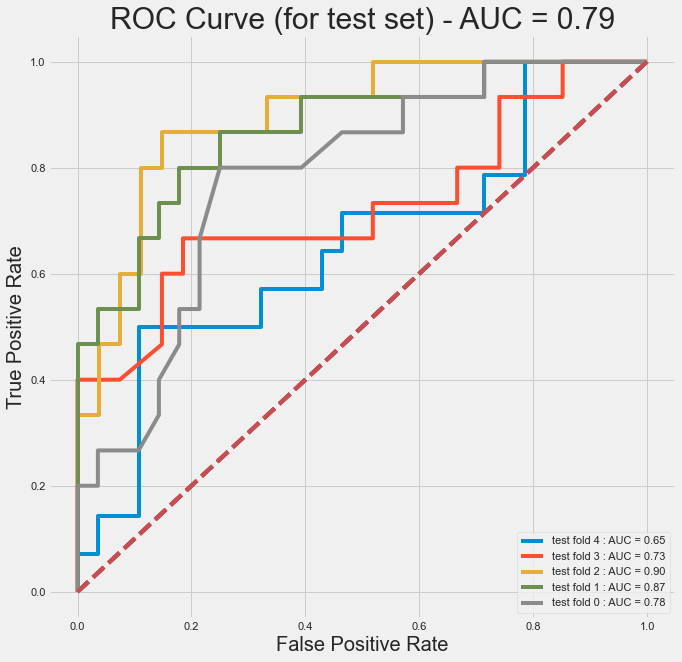

In [21]:
acc_ext = []
rocauc_ext = []
probs_ext = []
plt.figure(figsize=(10, 10))

# Scroll through whole dataset for 5-fold cross validation and testing
for i_test_fold in range(n_test_folds-1, -1, -1):
    test_indices = stratified_fold[i_test_fold]
    train_indices_list = stratified_fold[:i_test_fold] + stratified_fold[i_test_fold+1:]
    train_indices = [item for sublist in train_indices_list for item in sublist]

    shuffled_train_ind = np.random.choice(train_indices, len(train_indices), replace=False)
    shuffled_test_ind = np.random.choice(test_indices, len(test_indices), replace=False)
    X_train = X_data.iloc[shuffled_train_ind]
    Y_train = Y_data[shuffled_train_ind]
    X_test = X_data.iloc[shuffled_test_ind]
    Y_test = Y_data[shuffled_test_ind] 
    fit_train = imp0.fit(X_train)
    test_imputed = imp0.transform(X_test)
    train_imputed = imp0.transform(X_train)
    
    for i in range(len(X_train)):
        X_train.iloc[i] = train_imputed[i]
    for i in range(len(X_test)):
        X_test.iloc[i] = test_imputed[i]
    
    val_fold = StratifiedKFold(n_splits=n_val_folds, random_state=random_state)#, shuffle=True)
    ExtC = ExtraTreesClassifier()

    
    ## Search grid for optimal parameters
    ex_param_grid = {"max_depth": [None],
                  "max_features": [1, 3, 10, 20],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100, 300],
                  "criterion": ["gini"]}
    ex_param_dist = {"max_depth": [None],
                  "max_features": np.random.randint(1, 17, 15),
                  "min_samples_split": np.random.randint(2, 10, 5),
                  "min_samples_leaf": np.random.randint(1, 10, 5),
                  "bootstrap": [False, True],
                  "n_estimators" : np.random.randint(50, 300, 10),
                  "criterion": ["gini", "entropy"]}

    
    
    if cv_strategy == 'grid':
        clf = GridSearchCV(ExtC, param_grid = ex_param_grid, cv=val_fold, scoring="roc_auc", 
                           n_jobs= 8, verbose = 1)
    elif cv_strategy == 'random':
        clf = RandomizedSearchCV(ExtC, param_distributions= ex_param_dist, cv=val_fold, scoring="roc_auc",
                             n_jobs= 8, verbose = 1, n_iter=20)
    
   
    clf.fit(X_train,Y_train)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    ExtC_best = clf.best_estimator_
    

    y_true, y_pred = Y_test, clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    probs_ext.append(y_true)
    probs_ext.append(y_probs)

    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Accuracy:")
    accuracy_test_fold = accuracy_score(y_true, y_pred)
    print(accuracy_test_fold)
    acc_ext.append(accuracy_test_fold)
    print("ROC-AUC value:")
    rocauc_test_fold = roc_auc_score(y_true, y_probs[:,1])
    print(rocauc_test_fold)
    rocauc_ext.append(rocauc_test_fold)
    
    fpr, tpr, threshold = roc_curve(Y_test, y_probs[:,1])
    plt.plot(fpr, tpr, label = 'test fold {} : AUC = {:.2f}'.format(i_test_fold, rocauc_test_fold))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    
    
    print('==================================================================')
    
print("Acc. on test set = {}".format(np.mean(acc_ext)))
print("ROCAUC on test set = {}".format(np.mean(rocauc_ext)))
plt.title('ROC Curve (for test set) - AUC = {:.2f}'.format(np.mean(rocauc_ext)), fontsize=30)

### Gradient Boosting

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.1s finished


Best parameters set found on development set:
{'n_estimators': 108, 'min_samples_leaf': 9, 'max_features': 0.1, 'max_depth': 9, 'loss': 'deviance', 'learning_rate': 0.009725889135063523}
Confusion matrix:
[[26  2]
 [12  2]]
Accuracy:
0.6666666666666666
ROC-AUC value:
0.6964285714285715
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.3s finished


Best parameters set found on development set:
{'n_estimators': 269, 'min_samples_leaf': 56, 'max_features': 0.1, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.006326579396516805}
Confusion matrix:
[[27  0]
 [15  0]]
Accuracy:
0.6428571428571429
ROC-AUC value:
0.7777777777777778
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.0s finished


Best parameters set found on development set:
{'n_estimators': 190, 'min_samples_leaf': 39, 'max_features': 0.3, 'max_depth': 7, 'loss': 'deviance', 'learning_rate': 0.0809777708710762}
Confusion matrix:
[[23  4]
 [ 3 12]]
Accuracy:
0.8333333333333334
ROC-AUC value:
0.8864197530864197
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.1s finished


Best parameters set found on development set:
{'n_estimators': 127, 'min_samples_leaf': 12, 'max_features': 0.1, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.017108816254734465}
Confusion matrix:
[[26  2]
 [ 9  6]]
Accuracy:
0.7441860465116279
ROC-AUC value:
0.7785714285714286
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.9s finished


Best parameters set found on development set:
{'n_estimators': 269, 'min_samples_leaf': 13, 'max_features': 0.4, 'max_depth': 7, 'loss': 'deviance', 'learning_rate': 0.014407534078906908}
Confusion matrix:
[[20  8]
 [ 2 13]]
Accuracy:
0.7674418604651163
ROC-AUC value:
0.85
Acc. on test set = 0.7308970099667774
ROCAUC on test set = 0.7978395061728395


Text(0.5, 1.0, 'ROC Curve (for test set) - AUC = 0.80')

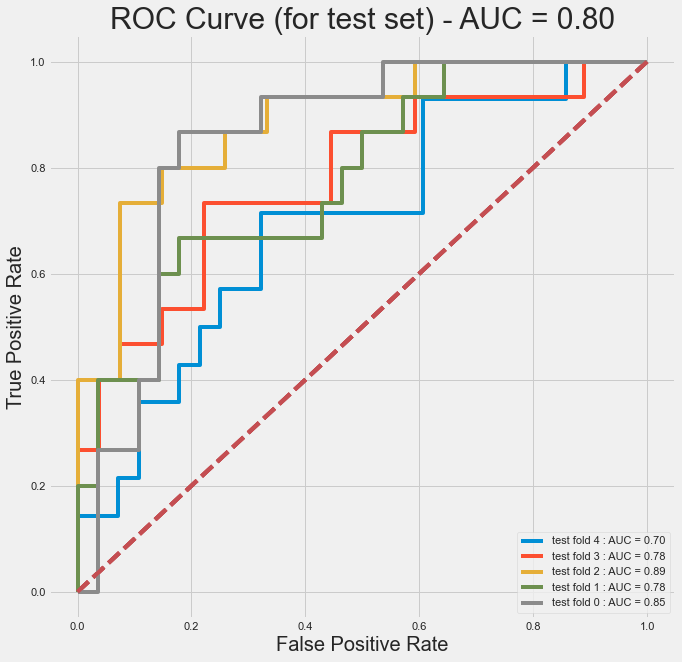

In [22]:
acc_gb = []
rocauc_gb = []
probs_gb = []
plt.figure(figsize=(10, 10))

# Scroll through whole dataset for 5-fold cross validation and testing
for i_test_fold in range(n_test_folds-1, -1, -1):
    test_indices = stratified_fold[i_test_fold]
    train_indices_list = stratified_fold[:i_test_fold] + stratified_fold[i_test_fold+1:]
    train_indices = [item for sublist in train_indices_list for item in sublist]

    shuffled_train_ind = np.random.choice(train_indices, len(train_indices), replace=False)
    shuffled_test_ind = np.random.choice(test_indices, len(test_indices), replace=False)
    X_train = X_data.iloc[shuffled_train_ind]
    Y_train = Y_data[shuffled_train_ind]
    X_test = X_data.iloc[shuffled_test_ind]
    Y_test = Y_data[shuffled_test_ind] 
    fit_train = imp0.fit(X_train)
    test_imputed = imp0.transform(X_test)
    train_imputed = imp0.transform(X_train)
    
    for i in range(len(X_train)):
        X_train.iloc[i] = train_imputed[i]
    for i in range(len(X_test)):
        X_test.iloc[i] = test_imputed[i]
    
    
    val_fold = StratifiedKFold(n_splits=n_val_folds, random_state=random_state)
        
    GBC = GradientBoostingClassifier()
    gb_param_grid = {'loss' : ["deviance"],
                  'n_estimators' : [100,200,300],
                  'learning_rate': [0.1, 0.05, 0.01],
                  'max_depth': [3, 4, 8],
                  'min_samples_leaf': [1, 100,150],
                  'max_features': [0.3, 0.1] 
                  }
    gb_param_dist = {'loss' : ["deviance"],
                  'n_estimators' : np.random.randint(50, 300, 20),
                  'learning_rate': 10**np.random.uniform(-1, -3, 5),
                  'max_depth': np.random.randint(3, 10, 6),
                  'min_samples_leaf': np.random.randint(1, 150, 5),
                  'max_features': [0.4, 0.3, 0.2, 0.1] 
                  }

    
    if cv_strategy == 'grid':
        clf = GridSearchCV(GBC, param_grid = gb_param_grid, cv=val_fold, scoring="roc_auc", n_jobs= 4, verbose = 1)
    elif cv_strategy =='random':
        clf = RandomizedSearchCV(GBC, param_distributions = gb_param_dist, cv=val_fold, scoring="roc_auc",
                             n_jobs= 4, verbose = 1, n_iter = 20)
    
    
    clf.fit(X_train,Y_train)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    GBC_best = clf.best_estimator_
    
    
    y_true, y_pred = Y_test, clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    probs_gb.append(y_true)
    probs_gb.append(y_probs)
 
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Accuracy:")
    accuracy_test_fold = accuracy_score(y_true, y_pred)
    print(accuracy_test_fold)
    acc_gb.append(accuracy_test_fold)
    print("ROC-AUC value:")
    rocauc_test_fold = roc_auc_score(y_true, y_probs[:,1])
    print(rocauc_test_fold)
    rocauc_gb.append(rocauc_test_fold)
    
    
    fpr, tpr, threshold = roc_curve(Y_test, y_probs[:,1])
    plt.plot(fpr, tpr, label = 'test fold {} : AUC = {:.2f}'.format(i_test_fold, rocauc_test_fold))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    
    print('==================================================================')
    
print("Acc. on test set = {}".format(np.mean(acc_gb)))
print("ROCAUC on test set = {}".format(np.mean(rocauc_gb)))
plt.title('ROC Curve (for test set) - AUC = {:.2f}'.format(np.mean(rocauc_gb)), fontsize=30)

### SVM

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


Best parameters set found on development set:
{'kernel': 'rbf', 'gamma': 2.370311948095698e-05, 'C': 218}
Confusion matrix:
[[23  5]
 [ 9  5]]
Accuracy:
0.6666666666666666
ROC-AUC value:
0.6071428571428571
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


Best parameters set found on development set:
{'kernel': 'rbf', 'gamma': 7.1399580756962855e-06, 'C': 814}
Confusion matrix:
[[22  5]
 [11  4]]
Accuracy:
0.6190476190476191
ROC-AUC value:
0.5456790123456791
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


Best parameters set found on development set:
{'kernel': 'rbf', 'gamma': 0.0010802023741843816, 'C': 661}
Confusion matrix:
[[27  0]
 [14  1]]
Accuracy:
0.6666666666666666
ROC-AUC value:
0.6691358024691358
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


Best parameters set found on development set:
{'kernel': 'rbf', 'gamma': 8.630464943363282e-06, 'C': 471}
Confusion matrix:
[[21  7]
 [ 9  6]]
Accuracy:
0.627906976744186
ROC-AUC value:
0.6047619047619048
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best parameters set found on development set:
{'kernel': 'rbf', 'gamma': 1.418018198415238e-06, 'C': 813}
Confusion matrix:
[[24  4]
 [ 9  6]]
Accuracy:
0.6976744186046512
ROC-AUC value:
0.7738095238095238
Acc. on test set = 0.6555924695459578
ROCAUC on test set = 0.6401058201058201


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


Text(0.5, 1.0, 'ROC Curve (for test set) - AUC = 0.64')

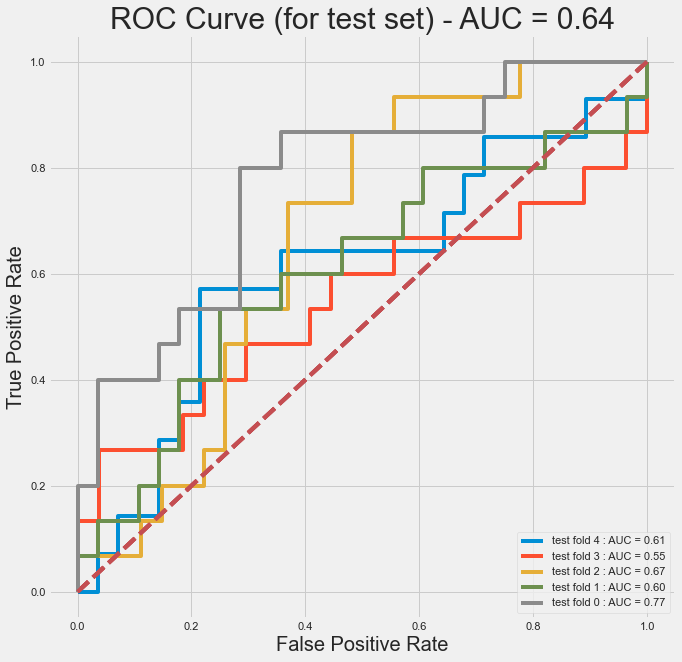

In [23]:
acc_svm = []
rocauc_svm = []
probs_svm = []
plt.figure(figsize=(10, 10))

# Scroll through whole dataset for 5-fold cross validation and testing
for i_test_fold in range(n_test_folds-1, -1, -1):
    test_indices = stratified_fold[i_test_fold]
    train_indices_list = stratified_fold[:i_test_fold] + stratified_fold[i_test_fold+1:]
    train_indices = [item for sublist in train_indices_list for item in sublist]

    shuffled_train_ind = np.random.choice(train_indices, len(train_indices), replace=False)
    shuffled_test_ind = np.random.choice(test_indices, len(test_indices), replace=False)
    X_train = X_data.iloc[shuffled_train_ind]
    Y_train = Y_data[shuffled_train_ind]
    X_test = X_data.iloc[shuffled_test_ind]
    Y_test = Y_data[shuffled_test_ind] 
    fit_train = imp0.fit(X_train)
    test_imputed = imp0.transform(X_test)
    train_imputed = imp0.transform(X_train)
    
    for i in range(len(X_train)):
        X_train.iloc[i] = train_imputed[i]
    for i in range(len(X_test)):
        X_test.iloc[i] = test_imputed[i]
    
    
    val_fold = StratifiedKFold(n_splits=n_val_folds, random_state=random_state)#, shuffle=True)
    
    
    SVMC = SVC(probability=True)
    svc_param_grid = {'kernel': ['rbf'], 
                      'gamma': [0.000001, 0.001, 0.01, 0.1, 1],
                      'C': [1, 10, 50, 100, 200,300, 1000]}
    svc_param_dist = {'kernel': ['rbf'], 
                      'gamma': 10**(np.random.uniform(-6, 1, 20)),
                      'C': np.random.randint(1, 1000, 20)}

    if cv_strategy == 'grid':
        clf = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=val_fold, scoring="roc_auc", n_jobs= 4, verbose = 1)
    elif cv_strategy == 'random':
        clf = RandomizedSearchCV(SVMC, param_distributions = svc_param_dist, cv=val_fold, 
                             scoring="roc_auc", n_jobs= 4, verbose = 1, n_iter=20)

    clf.fit(X_train,Y_train)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    SVMC_best = clf.best_estimator_

    
    
    y_true, y_pred = Y_test, clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    probs_svm.append(y_true)
    probs_svm.append(y_probs)

    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Accuracy:")
    accuracy_test_fold = accuracy_score(y_true, y_pred)
    print(accuracy_test_fold)
    acc_svm.append(accuracy_test_fold)
    print("ROC-AUC value:")
    rocauc_test_fold = roc_auc_score(y_true, y_probs[:,1])
    print(rocauc_test_fold)
    rocauc_svm.append(rocauc_test_fold)
    
    fpr, tpr, threshold = roc_curve(Y_test, y_probs[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'test fold {} : AUC = {:.2f}'.format(i_test_fold, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    
    print('==================================================================')
    
print("Acc. on test set = {}".format(np.mean(acc_svm)))
print("ROCAUC on test set = {}".format(np.mean(rocauc_svm)))
plt.title('ROC Curve (for test set) - AUC = {:.2f}'.format(np.mean(rocauc_svm)), fontsize=30)

### MLP

StratifiedKFold(n_splits=5, random_state=108, shuffle=False)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.7s finished


Best parameters set found on development set:
{'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10, 10), 'early_stopping': False, 'alpha': 0.10277800462298534}
Confusion matrix:
[[22  6]
 [ 6  8]]
Accuracy:
0.7142857142857143
ROC-AUC value:
0.6747448979591837
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  78 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   19.4s finished


Best parameters set found on development set:
{'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': 50, 'early_stopping': False, 'alpha': 0.00014630836397216862}
Confusion matrix:
[[22  5]
 [10  5]]
Accuracy:
0.6428571428571429
ROC-AUC value:
0.5777777777777778
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done  93 out of 100 | elapsed:   14.6s remaining:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   14.8s finished


Best parameters set found on development set:
{'max_iter': 100, 'learning_rate': 'constant', 'hidden_layer_sizes': 100, 'early_stopping': False, 'alpha': 7.645178673966861}
Confusion matrix:
[[22  5]
 [ 9  6]]
Accuracy:
0.6666666666666666
ROC-AUC value:
0.6913580246913581
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  47 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.5s finished


Best parameters set found on development set:
{'max_iter': 500, 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 10), 'early_stopping': False, 'alpha': 46.09187417630753}
Confusion matrix:
[[24  4]
 [ 8  7]]
Accuracy:
0.7209302325581395
ROC-AUC value:
0.7380952380952381
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s


Best parameters set found on development set:
{'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 100, 'early_stopping': False, 'alpha': 0.04447552557175532}
Confusion matrix:
[[28  0]
 [10  5]]
Accuracy:
0.7674418604651163
ROC-AUC value:
0.7071428571428572
Acc. on test set = 0.7024363233665559
ROCAUC on test set = 0.677823759133283


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   14.2s finished


Text(0.5, 1.0, 'ROC Curve (for test set) - AUC = 0.68')

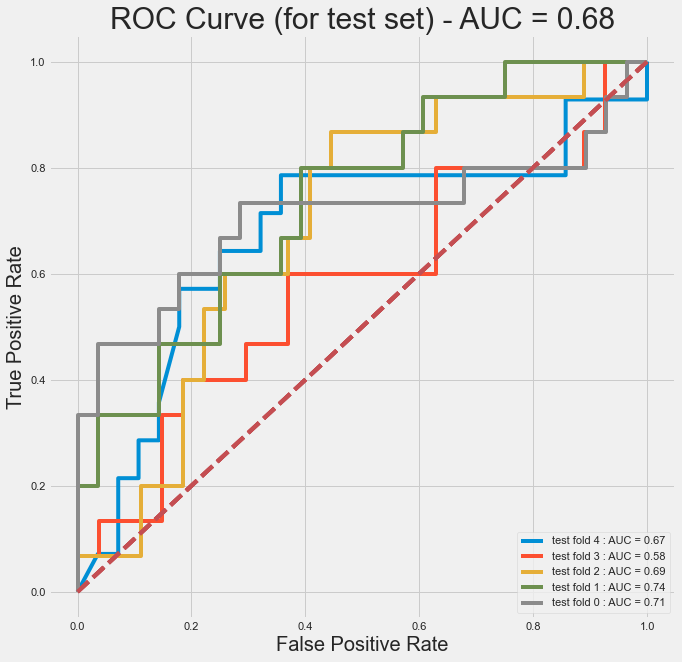

In [24]:
np.random.seed()
random_state=108
n_test_folds = 5
n_val_folds = 5
kfold = StratifiedKFold(n_splits=n_test_folds, random_state=random_state)#, shuffle=True)
print(kfold)
stratified_fold = []
for train_index, test_index in kfold.split(X_data, Y_data):
    stratified_fold.append(list(test_index))
    
    
acc_mlp = []
rocauc_mlp = []
probs_mlp = []
plt.figure(figsize=(10,10))

# Scroll through whole dataset for 5-fold cross validation and testing
for i_test_fold in range(n_test_folds-1, -1, -1):
    test_indices = stratified_fold[i_test_fold]
    train_indices_list = stratified_fold[:i_test_fold] + stratified_fold[i_test_fold+1:]
    train_indices = [item for sublist in train_indices_list for item in sublist]


    shuffled_train_ind = np.random.choice(train_indices, len(train_indices), replace=False)
    shuffled_test_ind = np.random.choice(test_indices, len(test_indices), replace=False)
    X_train = X_data.iloc[shuffled_train_ind]
    Y_train = Y_data[shuffled_train_ind]
    X_test = X_data.iloc[shuffled_test_ind]
    Y_test = Y_data[shuffled_test_ind] 
    fit_train = imp0.fit(X_train)
    test_imputed = imp0.transform(X_test)
    train_imputed = imp0.transform(X_train)
    for i in range(len(X_train)):
        X_train.iloc[i] = train_imputed[i]
    
    for i in range(len(X_test)):
        X_test.iloc[i] = test_imputed[i]
    
    
    val_fold = StratifiedKFold(n_splits=n_val_folds, random_state=random_state)
    
    MLP = MLPClassifier(random_state=random_state)
    mlp_param_grid = {"hidden_layer_sizes": [(10,), (50,), (100,), (10, 10), (25, 25)],
                     "alpha": [100.0, 10., 1.0, 0.1, 0.001, 0.0001],
                     "learning_rate": ["constant", "adaptive"],
                     "max_iter": [ 500, 1000],
                     "early_stopping": [True]}
    mlp_param_dist = {"hidden_layer_sizes": [(5,), (10,), (50), (100), (5,5,5), (10,10), (5,10,5), (25,25)],
                     "alpha": 10**np.random.uniform(-4, 2, 20),
                     "learning_rate": ["constant", "adaptive"],
                     "max_iter": [100, 500, 1000],
                     "early_stopping": [True, False]}

    if cv_strategy == 'grid':
        clf = GridSearchCV(MLP, param_grid = mlp_param_grid, cv=val_fold, scoring="roc_auc", n_jobs= 4, verbose = 1)
    elif cv_strategy == 'random':
        clf = RandomizedSearchCV(MLP, param_distributions=mlp_param_dist, cv=val_fold, 
                             scoring="accuracy", n_jobs= 4, verbose = 1, n_iter=20)

    clf.fit(X_train,Y_train)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    MLP_best = clf.best_estimator_
        
    
    y_true, y_pred = Y_test, clf.predict(X_test)
    y_probs =  clf.predict_proba(X_test)
    probs_mlp.append(y_true)
    probs_mlp.append(y_probs)

    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Accuracy:")
    accuracy_test_fold = accuracy_score(y_true, y_pred)
    print(accuracy_test_fold)
    acc_mlp.append(accuracy_test_fold)
    print("ROC-AUC value:")
    rocauc_test_fold = roc_auc_score(y_true, y_probs[:,1])
    print(rocauc_test_fold)
    rocauc_mlp.append(rocauc_test_fold)
    
    fpr, tpr, threshold = roc_curve(Y_test, y_probs[:,1])
    plt.plot(fpr, tpr, label = 'test fold {} : AUC = {:.2f}'.format(i_test_fold, rocauc_test_fold))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    
    print('==================================================================')
    
print("Acc. on test set = {}".format(np.mean(acc_mlp)))
print("ROCAUC on test set = {}".format(np.mean(rocauc_mlp)))
plt.title('ROC Curve (for test set) - AUC = {:.2f}'.format(np.mean(rocauc_mlp)), fontsize=30)

## Results

### Area under Receiver Operating Characteristic curve (ROC-AUC) and Accuracy values on test set

In [26]:
matrix_dict = {'Algorithm': ['AdaBoost', 'Random Forest', 'Extra Tree Classifier', 'Gradient Boosting', 'SVM', 'MLP'], 
               'accuracy': [acc_adaboost, acc_rf, acc_ext, acc_gb, acc_svm, acc_mlp], 
               'rocauc':[rocauc_adaboost, rocauc_rf, rocauc_ext, rocauc_gb, rocauc_svm, rocauc_mlp],
              'probs': [probs_adaboost, probs_rf, probs_ext, probs_gb, probs_svm, probs_mlp]}

acc_mean = []
acc_std = []
rocauc_mean = []
rocauc_std = []
for a, r, p, name in zip(matrix_dict['accuracy'], matrix_dict['rocauc'], 
                         matrix_dict['probs'], matrix_dict['Algorithm']):
    
    acc_mean.append(np.mean(a))
    acc_std.append(np.std(a))
    rocauc_mean.append(np.mean(r))
    rocauc_std.append(np.std(r))
    ll = []
    for i_test_fold in range(n_test_folds):
        ll.append(np.hstack((p[2*i_test_fold].to_numpy().reshape(-1, 1), p[(2*i_test_fold)+1])))
    probs_np = np.vstack(ll)

    import scipy.io as sio
    np.savetxt("probs_{}-Wout_labmarkers.csv".format(name), probs_np, delimiter=",")
    
    
matrix_df = pd.DataFrame({'Algorithm': ['AdaBoost', 'Random Forest', 'Extra Tree Classifier', 'Gradient Boosting', 'SVM', 'MLP'], 
                          'acc_mean': acc_mean, 'acc_std': acc_std, 'rocauc_mean': rocauc_mean, 'rocauc_std': rocauc_std})
matrix_df

Algorithm  acc_mean   acc_std  rocauc_mean  rocauc_std
0               AdaBoost  0.627243  0.092099     0.601032    0.088036
1          Random Forest  0.745072  0.032849     0.823321    0.047523
2  Extra Tree Classifier  0.754707  0.048970     0.786009    0.090280
3      Gradient Boosting  0.730897  0.069111     0.797840    0.065765
4                    SVM  0.655592  0.028699     0.640106    0.077423
5                    MLP  0.702436  0.043674     0.677824    0.054211

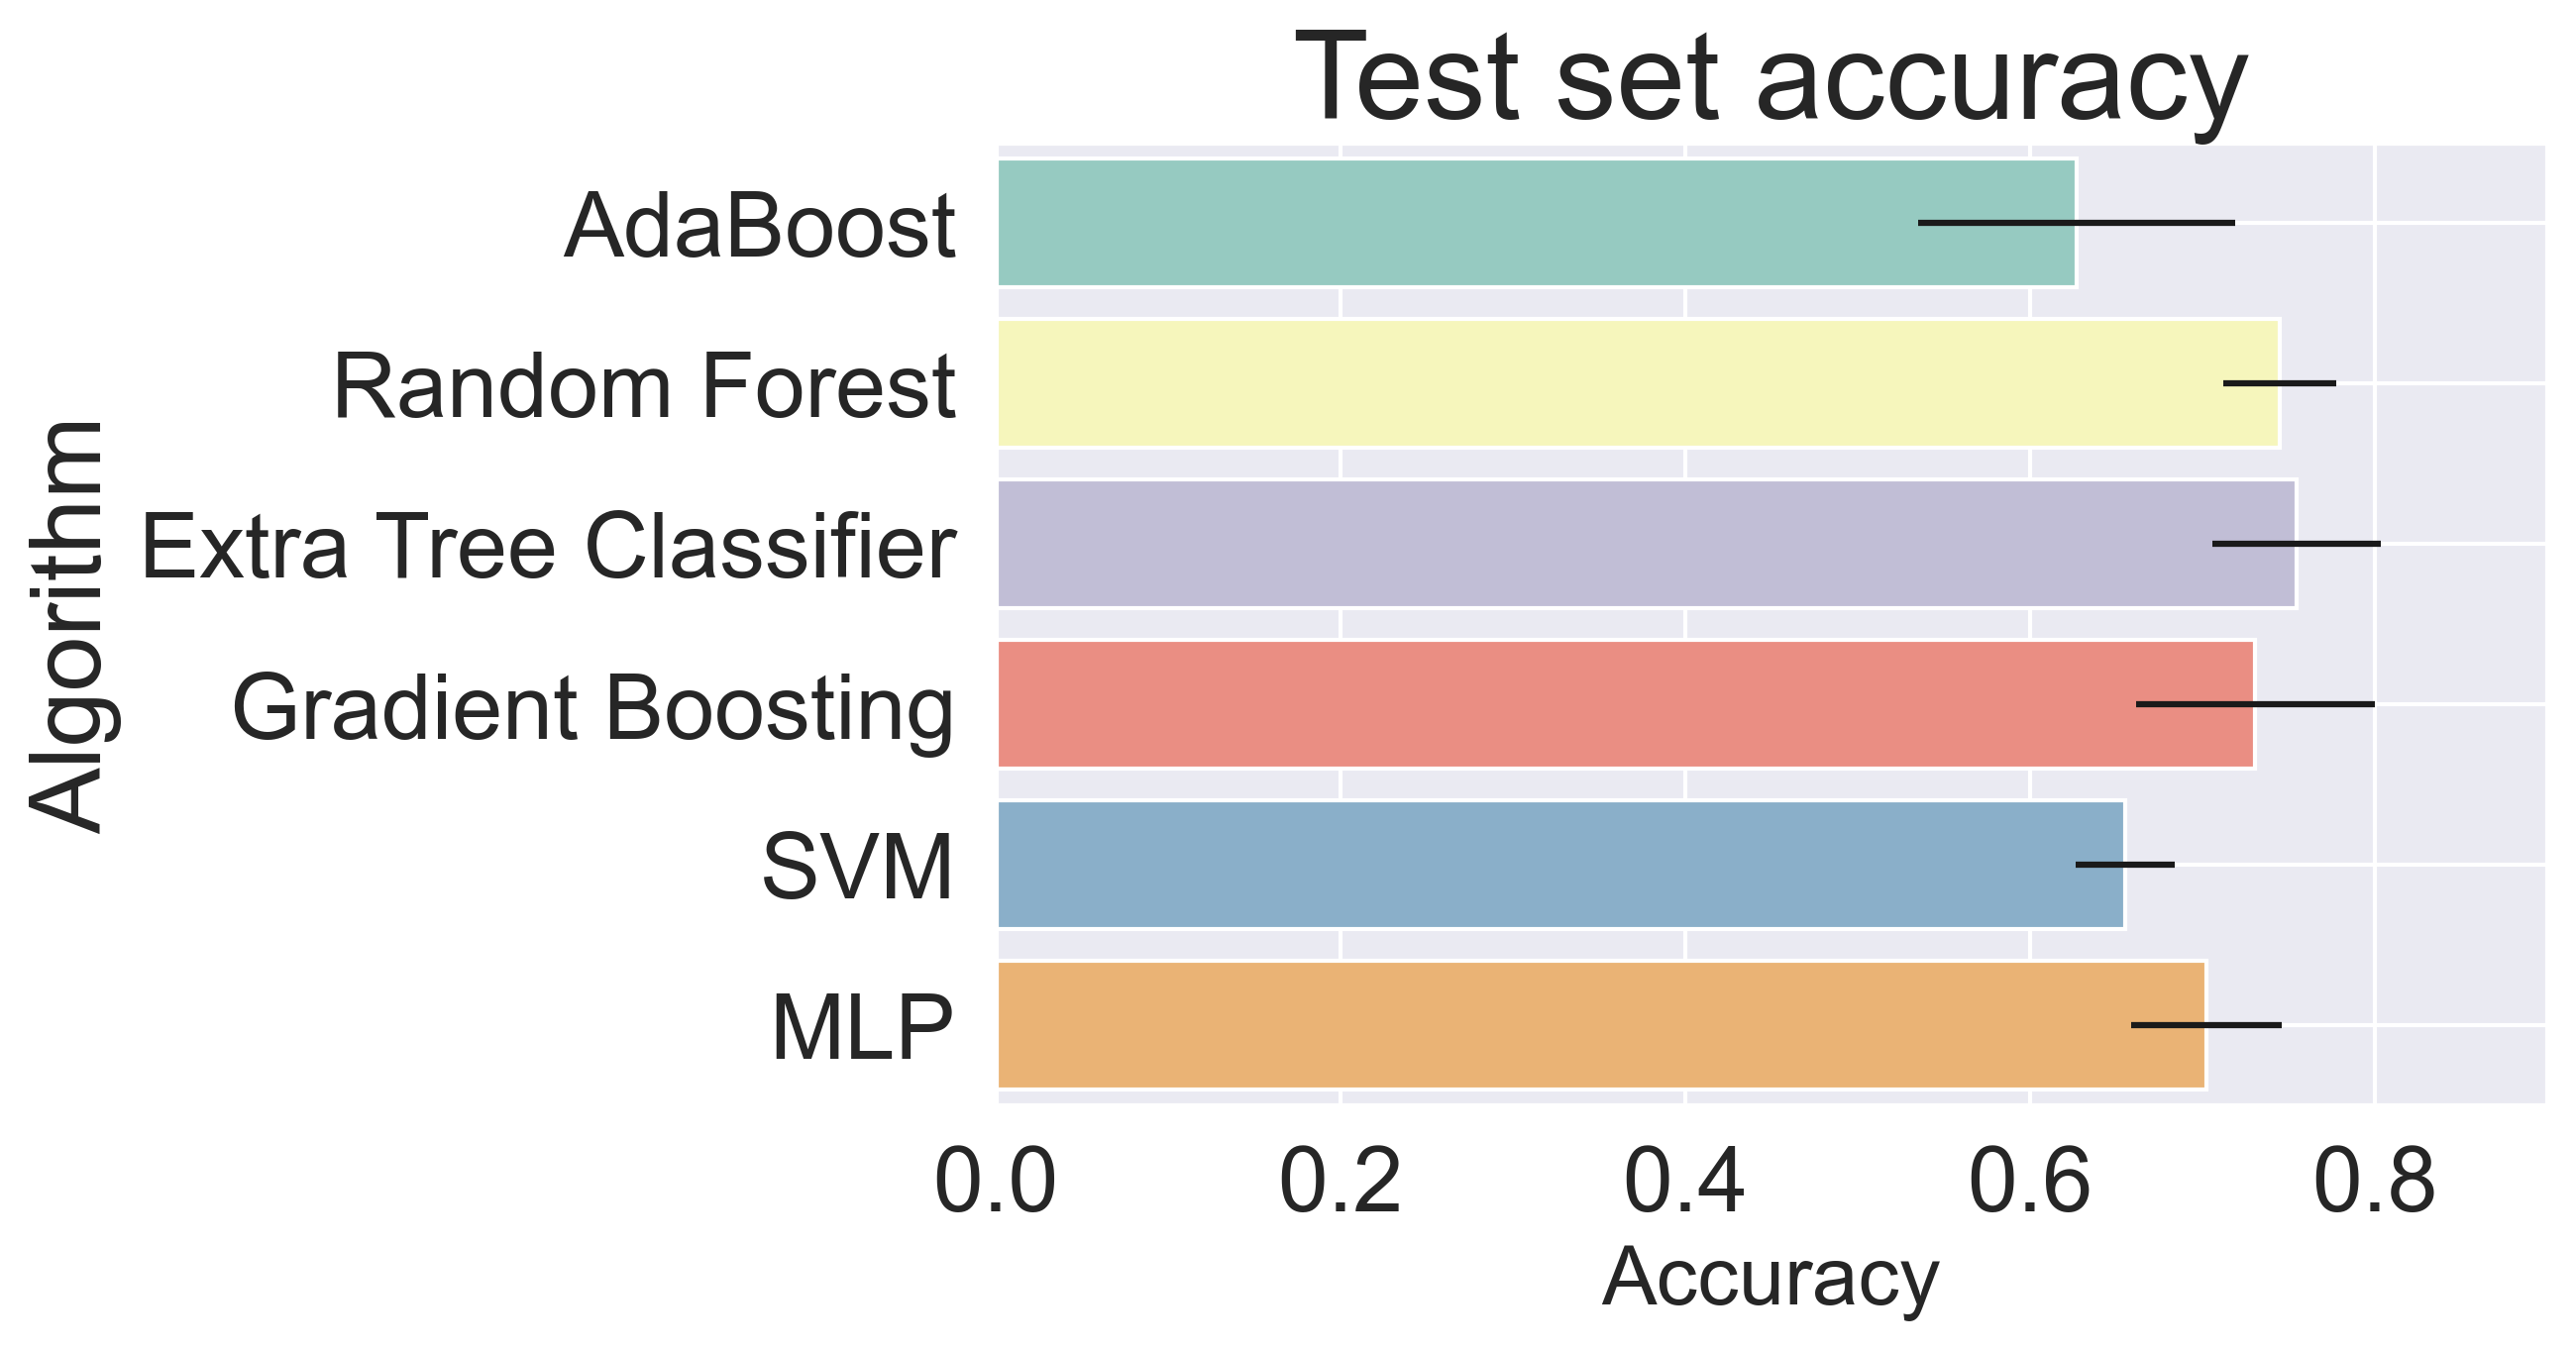

In [28]:
plt.figure(dpi=300)
sns.set(font_scale=2)
g = sns.barplot("acc_mean", "Algorithm", data = matrix_df, palette="Set3",orient = "h",**{'xerr':acc_std})
g.set_xlabel("Accuracy", fontsize=20)
g.set_xlim([0, 0.9])
g = g.set_title("Test set accuracy", fontsize=30)
plt.grid(True)

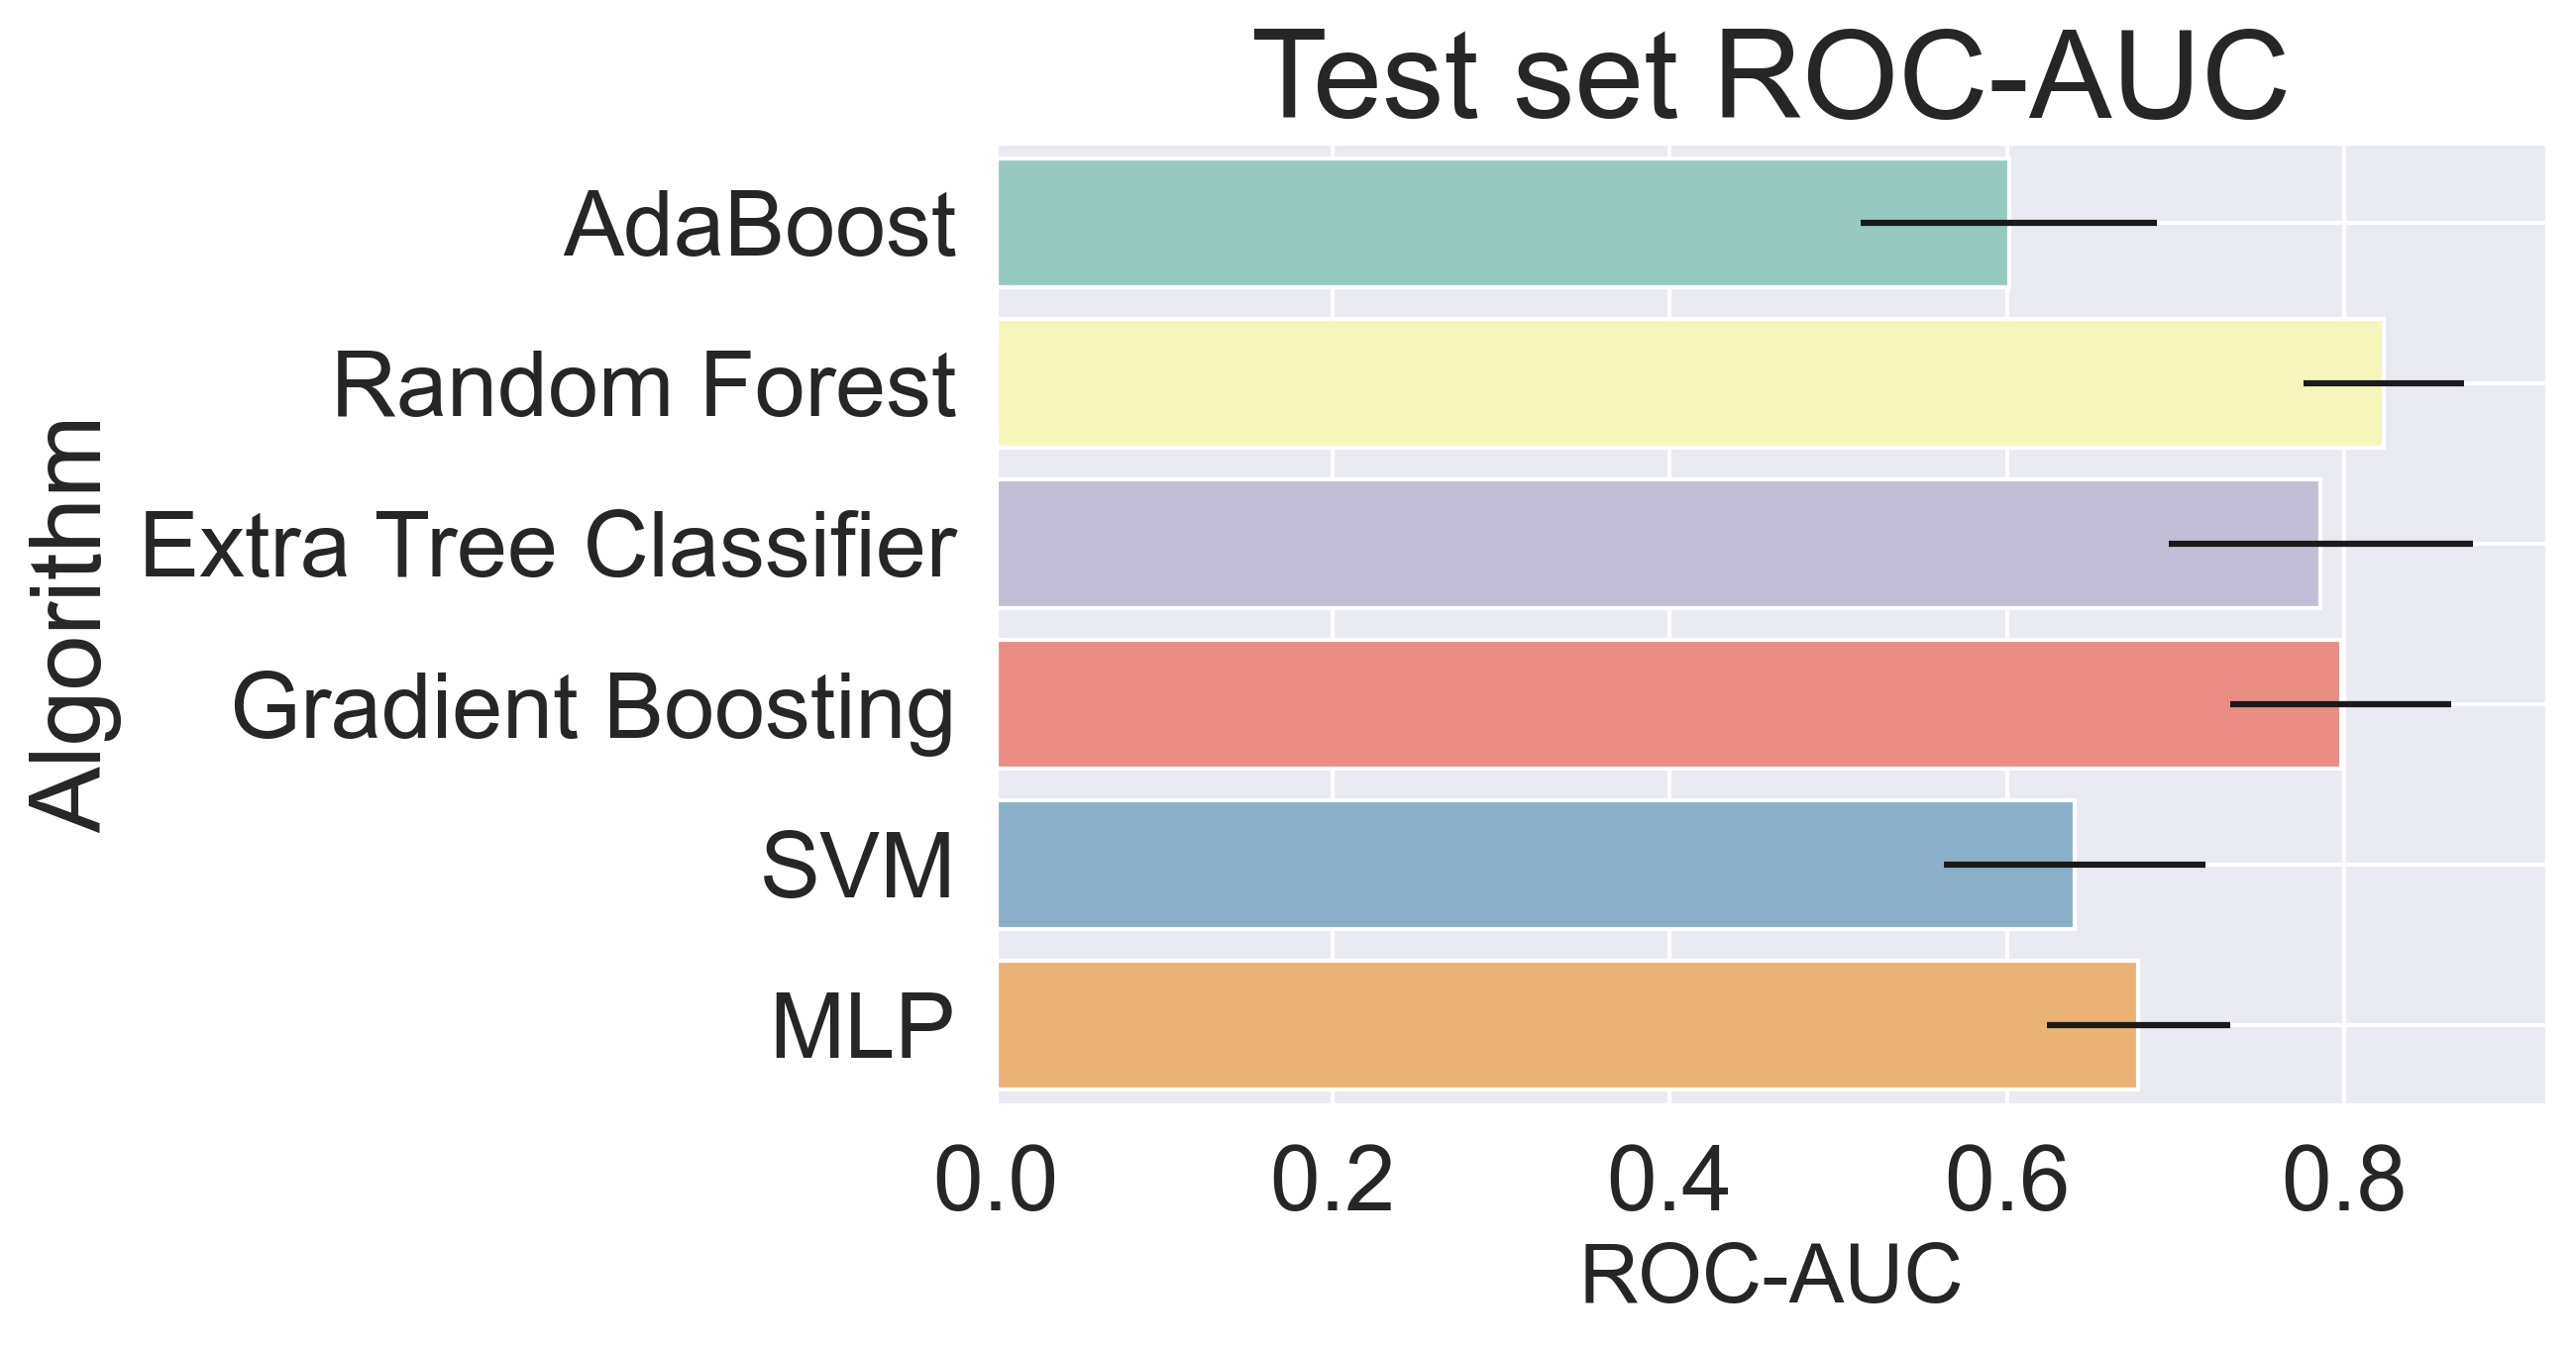

In [29]:
plt.figure(dpi=300)
sns.set(font_scale=2)
g = sns.barplot("rocauc_mean", "Algorithm", data = matrix_df, palette="Set3",orient = "h",**{'xerr':rocauc_std})
g.set_xlabel("ROC-AUC", fontsize=20)
g = g.set_title("Test set ROC-AUC", fontsize=30)
plt.grid(True)

Out of all 6 models, Random Forest is performing best giving highest value of area under ROC curve (0.82). Let's look at the 10 most important features used by this model to perform classification.

### Feature importance for the best model

In [30]:
X_train.rename(columns={"Bicarbonate (Total CO2)":"Bicarbonate"}, inplace=True)

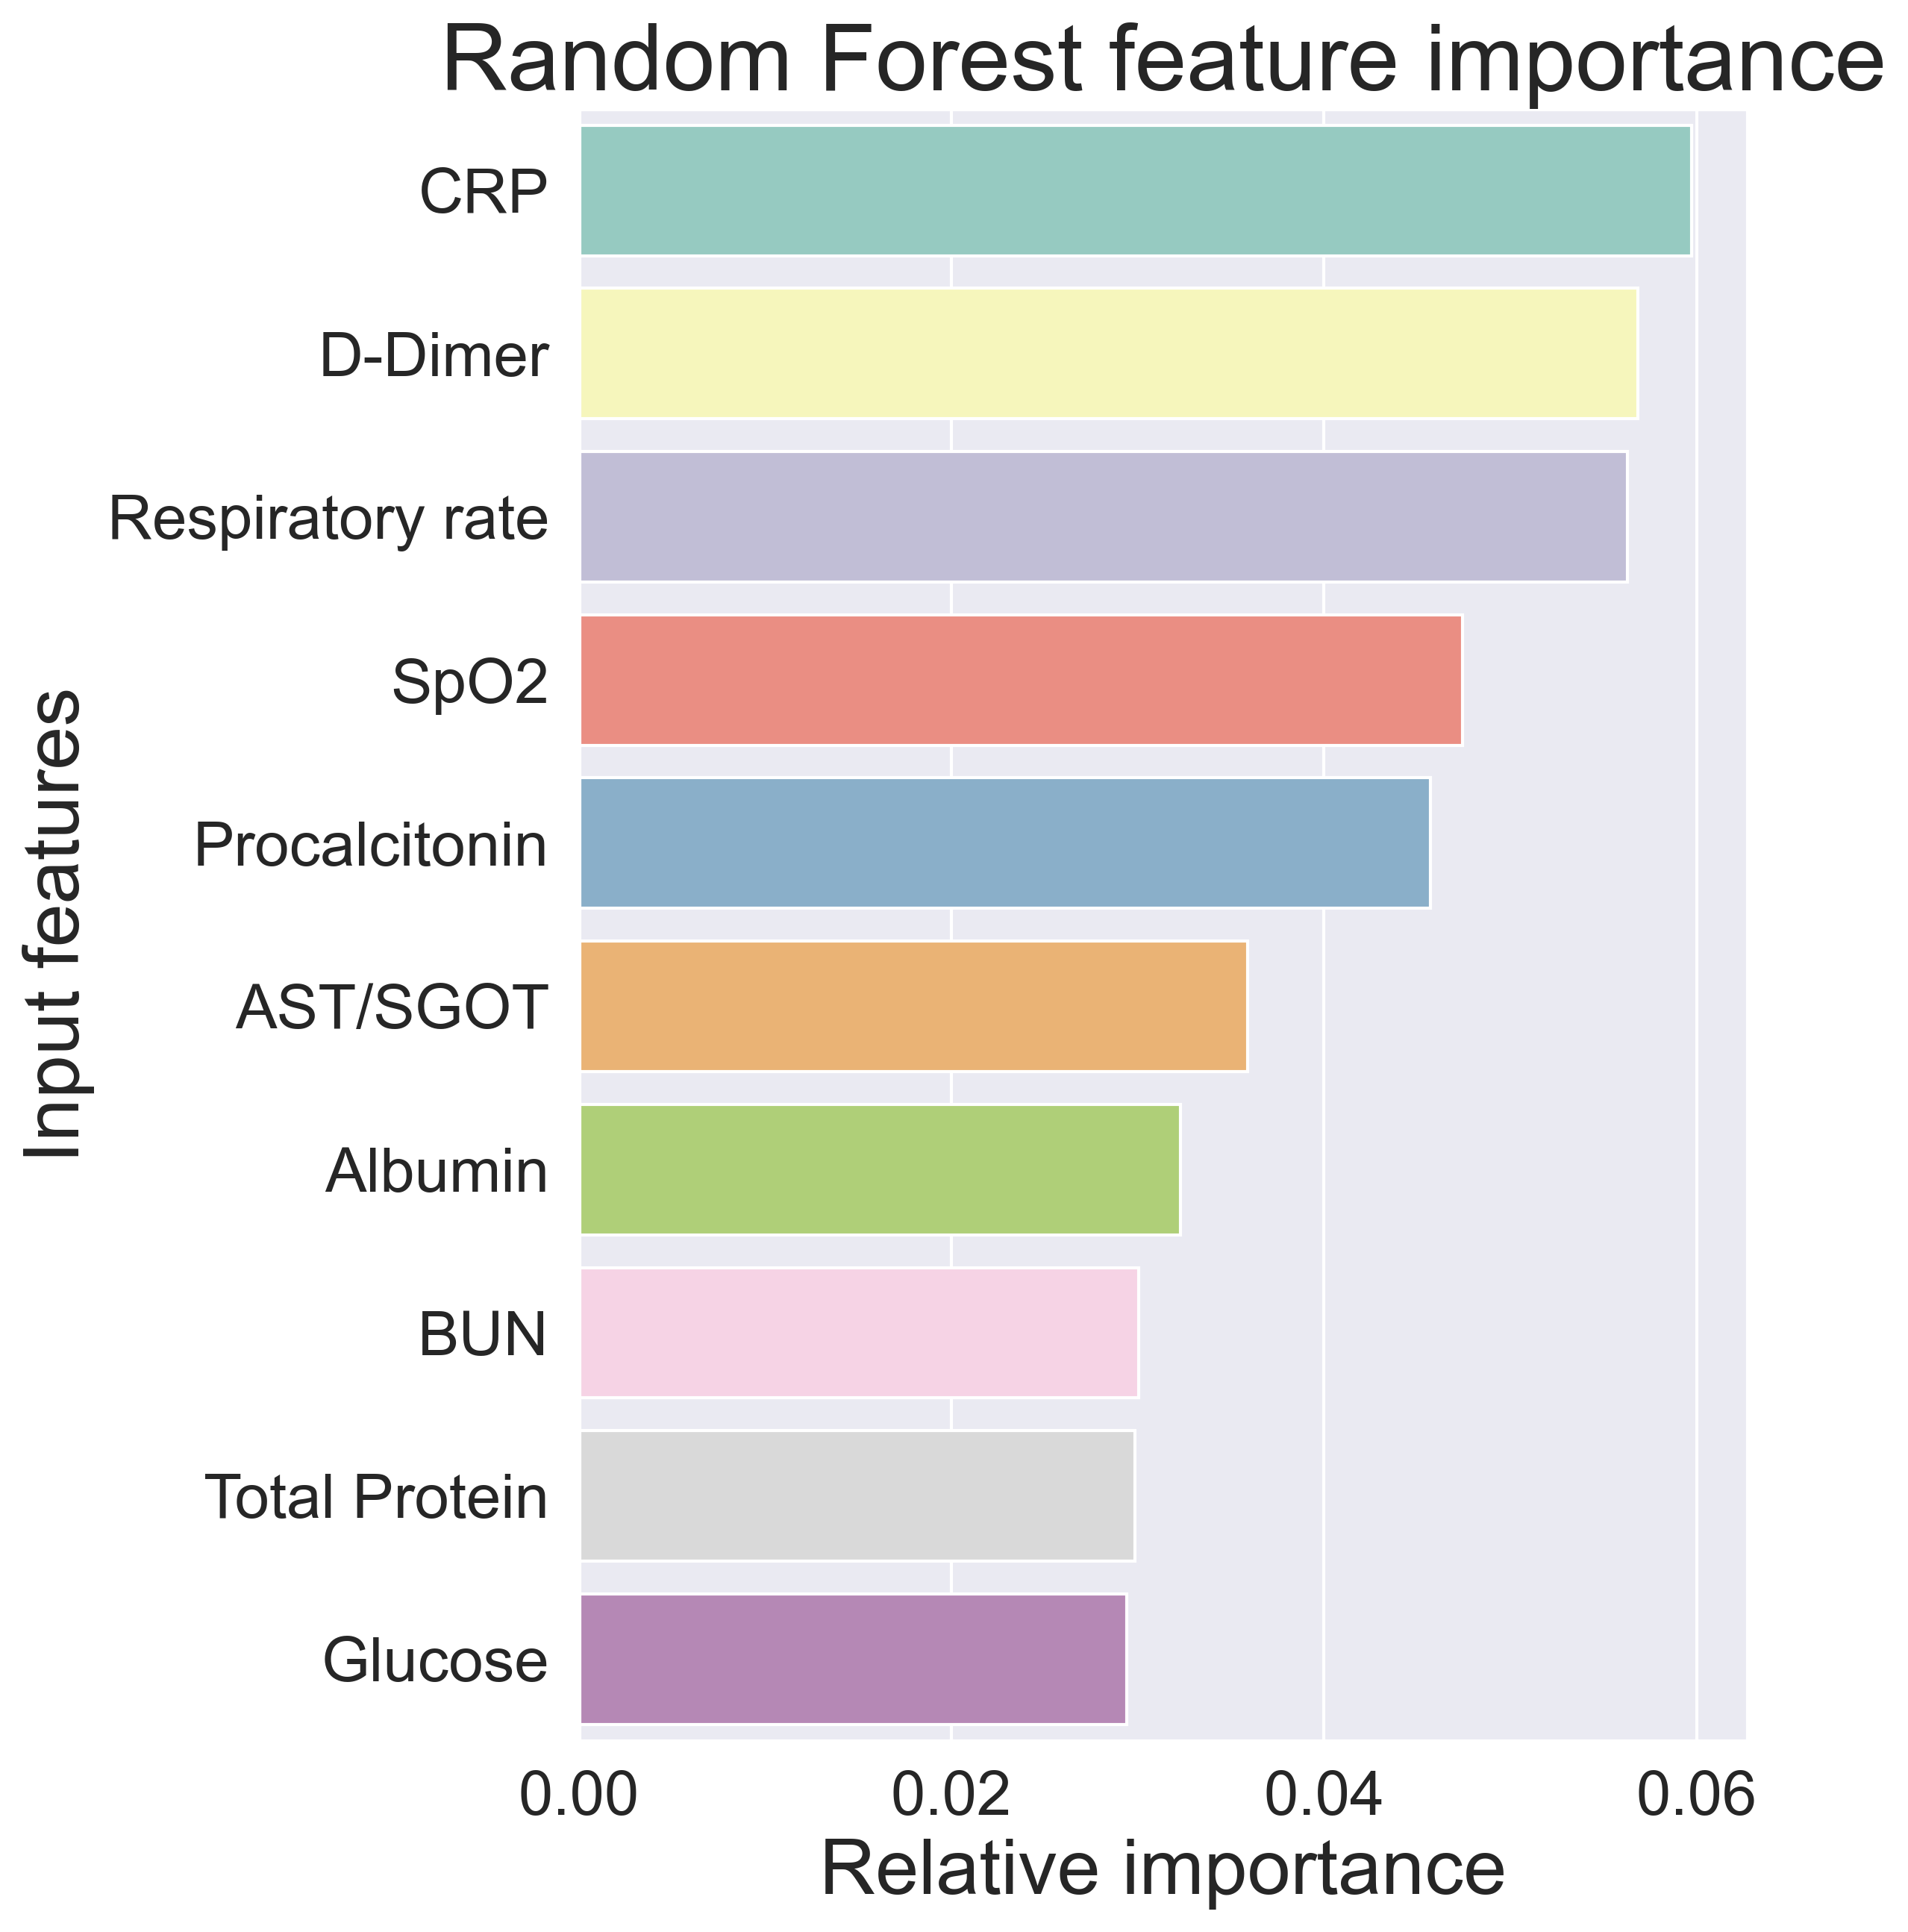

In [31]:
nrows = 1
ncols = 1
sns.set(font_scale=1.)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(6, 9), dpi=300)

names_classifiers = [("Random Forest", RFC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(np.mean(feat_imp_rf, axis=1))[::-1][:10]
        
        g = sns.barplot(y=X_train.columns[indices][:10], x = np.mean(feat_imp_rf, axis=1)[indices][:10], 
                        orient='h', palette='Set3')#,ax=axes[row])
        g.set_xlabel("Relative importance",fontsize=25)
        g.set_ylabel("Input features",fontsize=25)
        g.tick_params(labelsize=20)
        g.set_title(name + " feature importance", fontsize=30)
        nclassifier += 1

Feature importance plot indicates that CRP, D-dimer, Respiratory rate, and SPO2 are the most important feature in determisning whether a given patient will need ICU care or not in the future. This matches  well with many recent studies in the literature.
Let's look at the distribution of these features in patients which required ICU-care and which did not.

#### CRP

Text(0.5, 0, 'CRP')

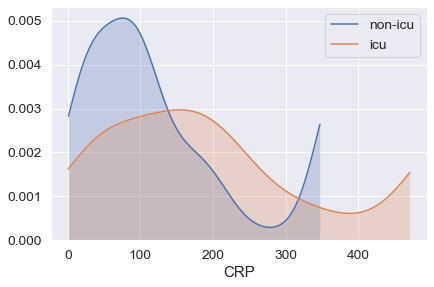

In [37]:
plt.figure()
sns.set(font_scale=1.25)
g = sns.kdeplot(dataset.loc[dataset.icu_outcome==0]['CRP'], cut=0, shade=True, label='non-icu')
g = sns.kdeplot(dataset.loc[dataset.icu_outcome==1]['CRP'], cut=0, shade=True, label='icu')
plt.xlabel("CRP")

As can be observed in the above figure, the mean and mode of CRP in patients that require ICU care is higher than those that do not require it.

#### SpO2

Text(0.5, 0, 'SPO2')

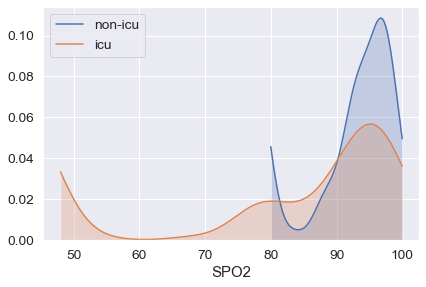

In [40]:
plt.figure()
sns.set(font_scale=1.25)
g = sns.kdeplot(dataset.loc[dataset.icu_outcome==0]['SpO2'], cut=0, shade=True, label='non-icu')
g = sns.kdeplot(dataset.loc[dataset.icu_outcome==1]['SpO2'], cut=0, shade=True, label='icu')
plt.xlabel("SpO2")

The average value of SpO2 is much lower in patients requiring ICU care than those that do not require it. This again matches with the clinical observations, as patients with low oxygen saturation typically require external breathing support and critical care (including ventilation) and hence are usually admitted to ICU.

## Extra model: Gradient boosting with XGBoost

Let's look at gradient boosting model once again, but using more powerful and efficient XGBoost library. [XGBoost](https://xgboost.readthedocs.io/en/latest/) stands for Extreme Gradient Boosting; it is a specific implementation of the Gradient Boosting method which uses more accurate approximations to find the best tree model. Specifically, it uses second order gradient information of loss function and advanced regularization techniques for better generalization.

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
Accuracy: 69.05%
Confusion matrix = [[23  5]
 [ 8  6]]
[1.9799297  0.97992975 0.9509403  0.6988288  0.63654697 0.5882252
 0.4136603  0.22322994 0.17468299 0.13927019 0.12212603 0.02467553
 0.02389315 0.02301938 0.02224152 0.0048611  0.00477877 0.00438693]
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance

Text(0.5, 1.0, 'ROC Curve (for test set) - AUC = 0.76')

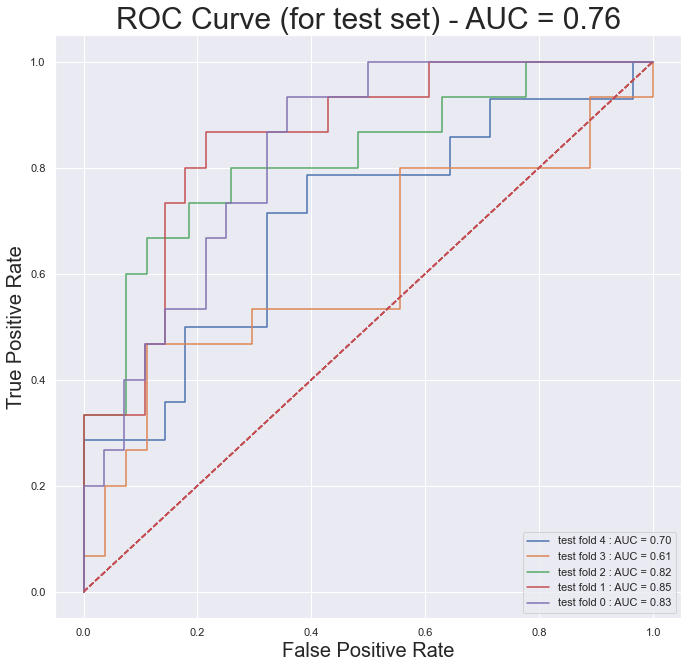

In [33]:
random_state = 108
n_test_folds = 5

kfold = StratifiedKFold(n_splits=n_test_folds, random_state=random_state)#, shuffle=True)
stratified_fold = []
for train_index, test_index in kfold.split(X_data, Y_data):
    stratified_fold.append(list(test_index))


acc_xgboost = []
rocauc_xgboost = []
plt.figure(figsize=(10, 10))
for i_test_fold in range(n_test_folds-1, -1, -1):
    test_indices = stratified_fold[i_test_fold]
    train_indices_list = stratified_fold[:i_test_fold] + stratified_fold[i_test_fold+1:]
    train_indices = [item for sublist in train_indices_list for item in sublist]


    shuffled_train_ind = np.random.choice(train_indices, len(train_indices), replace=False)
    shuffled_test_ind = np.random.choice(test_indices, len(test_indices), replace=False)
    X_train = X_data.iloc[shuffled_train_ind]
    Y_train = Y_data[shuffled_train_ind]
    X_test = X_data.iloc[shuffled_test_ind]
    Y_test = Y_data[shuffled_test_ind] 


    # fit model no training data
    model = XGBClassifier()
    model.fit(X_train, Y_train)

    print(model)

    # make predictions for test data
    y_pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)
    #print(pred_prob)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(Y_test, predictions)
    acc_xgboost.append(accuracy)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    conf_mat = confusion_matrix(Y_test, predictions)
    print('Confusion matrix = {}'.format(conf_mat))



    fpr, tpr, threshold = roc_curve(Y_test, pred_prob[:,1])
    roc_auc = auc(fpr, tpr)
    rocauc_xgboost.append(roc_auc)
    plt.plot(fpr, tpr, label = 'test fold {} : AUC = {:.2f}'.format(i_test_fold, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)

    print(threshold)

print("Final ROCAUC = {}".format(np.mean(rocauc_xgboost)))
plt.title('ROC Curve (for test set) - AUC = {:.2f}'.format(np.mean(rocauc_xgboost)), fontsize=30)


Apparently, XGBoost (AUC=0.76) does not seem to perform better than standard gradient boosting (AUC=0.79) algorithm for this dataset for a given classification task.